# The stability of the global average on different window lengths
This notebook outllines different methods that can be used to de-trend the LongRunMIP and ZECMIP time series.

In [1]:
# Standard Library Imports
import os
import sys
from typing import List, Any, Callable, Union, Tuple, Optional
from importlib import reload
from time import sleep
# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import climtas
from typing import NamedTuple
from enum import Enum
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from functools import partial
from glob import glob
import cftime
import string
from numpy.typing import ArrayLike
# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'zecmip_stabilisation'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_zecmip
import utils
# import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import zec_calculation_functions
import signal_to_noise_calculations as sn_calc

# import drift_functions
import sn_plotting
import my_stats
# import signal_to_noise_calculations as sn_calc

# import sn_plotting_utils
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning, module='dask.*')
warnings.filterwarnings("ignore", category=Warning)
# # Logging
# logger = utils.get_notebook_logger()

Matplotlib created a temporary config/cache directory at /jobfs/123053628.gadi-pbs/matplotlib-jm3vgn6v because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'list_xarray'))
# from listXarray import listXarray
# import listXarray as lxr
from listXarray import listXarray, where, apply_ufunc, read_listxarray
# reload(lxr)
# from listXarray import array_function

In [3]:
# import listXarray
# reload(listXarray)
# from listXarray import listXarray

In [4]:
np.set_printoptions(precision=2, suppress=True, edgeitems=1)
xr.set_options(display_expand_data=False)

In [5]:
# client.close()

In [6]:
from dask.distributed import Client
client = Client(memory_limit=None, threads_per_worker=1, n_workers=12)
client

- State start
-   Scheduler at:     tcp://127.0.0.1:34585
-   dashboard at:         /proxy/8787/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:35381'
-         Start Nanny at: 'tcp://127.0.0.1:33089'
-         Start Nanny at: 'tcp://127.0.0.1:41815'
-         Start Nanny at: 'tcp://127.0.0.1:37771'
-         Start Nanny at: 'tcp://127.0.0.1:46123'
-         Start Nanny at: 'tcp://127.0.0.1:36143'
-         Start Nanny at: 'tcp://127.0.0.1:45985'
-         Start Nanny at: 'tcp://127.0.0.1:36137'
-         Start Nanny at: 'tcp://127.0.0.1:43421'
-         Start Nanny at: 'tcp://127.0.0.1:37705'
-         Start Nanny at: 'tcp://127.0.0.1:41541'
-         Start Nanny at: 'tcp://127.0.0.1:46633'
- Register worker <WorkerState 'tcp://127.0.0.1:33211', name: 7, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:33211
- Starting established connection to tcp://127.0.0.1:42218
- Register worker <WorkerState 'tcp://127

<Client: 'tcp://127.0.0.1:34585' processes=12 threads=12>

- Register worker <WorkerState 'tcp://127.0.0.1:35431', name: 14, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:35431
- Starting established connection to tcp://127.0.0.1:51016
- Register worker <WorkerState 'tcp://127.0.0.1:37965', name: 13, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:37965
- Starting established connection to tcp://127.0.0.1:51028
- Register worker <WorkerState 'tcp://127.0.0.1:43953', name: 15, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:43953
- Starting established connection to tcp://127.0.0.1:51050
- Register worker <WorkerState 'tcp://127.0.0.1:44869', name: 16, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:44869
- Starting established connection to tcp://127.0.0.1:51036
- Register worker <WorkerState 'tcp://127.0.0.1:43403', name: 12, status: init, memory: 0, processing: 0>
- Starting

# Calculations

## Opening Data

In [7]:
chunks = {'lat':-1, 'lon':-1, 'time':-1, 'ensemble':-1}

In [8]:
a1_raw_data = (open_zecmip.extract_experiment_into_xrlist(
    '1000pgc', 'tas', chunks=chunks, logginglevel='ERROR')
                 .to_dataarray('tas')
                 .sort_by_refkey())

In [9]:
a1_raw_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1212, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1800, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'ensemble': 5, 'model': 1, 'time': 1200, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'ensemble': 1, 'model': 1, 'time': 2400, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'ensemble': 1, 'model': 1, 'time': 2160, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'ensemble': 1, 'model': 1, 'time': 2976, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'ensemble': 1, 'model': 1, 'time': 2220, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1200, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'ensemble': 4, 'model': 1, 'time': 3960, 'lat': 144, 'lon': 192})

In [10]:
a1_raw_data.sel(model=['CESM2', 'NorESM2-LM'])

key_dim = model


Number of da/ds: 2
---------------
CESM2      (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1800, 'lat': 192, 'lon': 288})
NorESM2-LM (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1200, 'lat': 96, 'lon': 144})

In [11]:
a1_raw_data.isel(model=[1,2,4])

key_dim = model


Number of da/ds: 3
---------------
ACCESS-ESM1-5 (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1800, 'lat': 192, 'lon': 288})
CESM2         (dataArray): ({'ensemble': 5, 'model': 1, 'time': 1200, 'lat': 64, 'lon': 128})
CanESM5       (dataArray): ({'ensemble': 1, 'model': 1, 'time': 2160, 'lat': 90, 'lon': 144})

In [12]:
pct_raw_data =  (open_zecmip.extract_experiment_into_xrlist('1pct', 'tas', chunks=chunks)
                   .to_dataarray('tas')
                   .sort_by_refkey())

In [13]:
# pi-Control (not ESM)
esmpi_raw_data = (open_zecmip.extract_experiment_into_xrlist('picontrol', 'tas', chunks=chunks, logginglevel='INFO')
                    .to_dataarray('tas')
                    .isel(ensemble=0)
                    .squeeze('ensemble')
                    .sort_by_refkey()
                    .rename({'latitude':'lat', 'longitude': 'lon'}))

- ACCESS-ESM1-5
-      r1i1p1f1 - /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/v20210316/*.nc
- CanESM5
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Amon/tas/gn/v20190429/*.nc
-      r1i1p2f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823/*.nc
- UKESM1-0-LL
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20200828/*.nc
- MPI-ESM1-2-LR
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r1i1p1f1/Amon/tas/gn/v20190710/*.nc
-      r2i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r2i1p1f1/Amon/tas/gn/v20190815/*.nc
- GISS-E2-1-G-CC
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G-CC/piControl/r1i1p1f1/Amon/tas/gn/v2

In [14]:
### ESM-pi-Control
# esmpi_raw_data = (open_zecmip.extract_experiment_into_data('esm-piControl', 'tas', logginglevel='INFO') #esm-piControl'
#                     .to_dataarray('tas')
#                     # .isel(ensemble=0)
#                     # .squeeze('ensemble')
#                     .sort_by_refkey()
#                     .rename({'latitude':'lat', 'longitude': 'lon'}))

In [15]:
esmpi_raw_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 12000, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'time': 14400, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'model': 1, 'time': 16800, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 6000, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 1980, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'model': 1, 'time': 6000, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 12000, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'time': 6012, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'model': 1, 'time': 22560, 'lat': 144, 'lon': 192})

In [16]:
# Making sure that the ensembles match. NOTE -  this can not be done
# with the piControl
a1_raw_data = a1_raw_data.cross_match_dim(pct_raw_data, 'ensemble')
pct_raw_data = pct_raw_data.cross_match_dim(a1_raw_data, 'ensemble')

In [17]:
# We are just looking at a single ensemble here.
a1_raw_data = a1_raw_data.isel(ensemble=0)
pct_raw_data = pct_raw_data.isel(ensemble=0)
esmpi_raw_data = esmpi_raw_data.isel(ensemble=0)

In [18]:
mask_ds = xr.open_dataset(os.path.join(constants.ZECMIP_LOCAL_DIR, 'landsea_mask.nc')) #_regridd_MPI_ESM
# mask_data = xr.open_dataset(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'landsea_mask_regridd_MPI_ESM.nc')); mask_data
mask_ds

<xarray.Dataset> Size: 150kB
Dimensions:  (lat: 96, lon: 192)
Coordinates:
  * lat      (lat) float64 768B -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Data variables:
    mask     (lat, lon) int64 147kB ...
Attributes:
    Original model:  Made from data found at /g/data/oi10/replicas/CMIP6/C4MI...

In [19]:
import xesmf
regridded_file_list = []
for model in a1_raw_data.model:
    print(model)
    
    target_ds = a1_raw_data[model].isel(time=0).squeeze().drop(['ensemble', 'model', 'time'])
    
    regridder = xesmf.Regridder(mask_ds.mask , target_ds, method='nearest_s2d')
    regridded_file = regridder(mask_ds.mask)
    regridded_file = regridded_file.expand_dims(model=[model])
    regridded_file_list.append(regridded_file)

mask_data = listXarray(regridded_file_list, 'model')

ACCESS-ESM1-5


[gadi-cpu-spr-0104.gadi.nci.org.au:3304493] shmem: mmap: an error occurred while determining whether or not /jobfs/123053628.gadi-pbs/ompi.gadi-cpu-spr-0104.13954/jf.0/313458688/shared_mem_cuda_pool.gadi-cpu-spr-0104 could be created.
[gadi-cpu-spr-0104.gadi.nci.org.au:3304493] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


CESM2
CanESM5
GFDL-ESM4
GISS-E2-1-G-CC
MIROC-ES2L
MPI-ESM1-2-LR
NorESM2-LM
UKESM1-0-LL


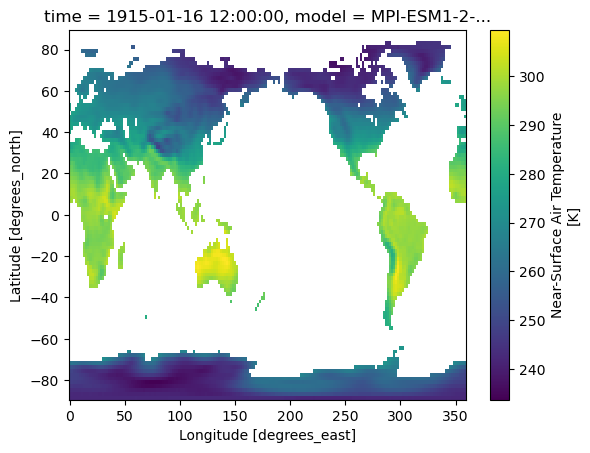

In [20]:
a1_raw_data[6].where(mask_data[6]).isel(time=0).plot()

In [21]:
# Convert to celcius
a1_raw_data = a1_raw_data - 273.15
pct_raw_data = pct_raw_data - 273.15
esmpi_raw_data = esmpi_raw_data - 273.15

In [22]:
# Can remove a lot of data, as I don't actually need this past the 70 year mark
# Data is montly so times by 12, a do 100 points just for saftery
pct_raw_data = pct_raw_data.isel(time=slice(0, 100 * 12))

In [23]:
# Yearly data transfomration - montly resolution is not needed
esmpi_data = esmpi_raw_data.chunk({'time':-1}).resample(time='Y').mean(dim='time').set_refkeys('model')
pct_resample_data = pct_raw_data.chunk({'time':-1}).resample(time='Y').mean(dim='time').set_refkeys('model')
a1_data = a1_raw_data.chunk({'time':-1}).resample(time='Y').mean(dim='time').set_refkeys('model')

# Can see this in the global mean time series. But this has errors after 1000
esmpi_data['CanESM5'] = esmpi_data['CanESM5'].isel(time=slice(None, 1000))

In [24]:
# Reduce time so that the smalles time densions matches. This is at 101 years
a1_data = a1_data.isel(time=slice(None, 100))

## Regridding Data

In [25]:
def regrid_with_climtas(ds, target_data):
        regridder = climtas.regrid.Regridder(ds, target_data)
        regridded_data = regridder.regrid(ds).compute()
        # Sometimes the re-gridd will remove the coordinates from the array
        coord_dict = dict(lat=regridded_data.lat.values, lon=regridded_data.lon.values)

        regridded_data=regridded_data.assign_coords(coord_dict)
        return regridded_data

In [26]:
def regrid_listxarray(lxr, target_model):
    regridd_list = []
    for model in range(len(lxr)):
        print(f'{model}, ', end='')
        regridded_data = regrid_with_climtas(lxr[model] , lxr[target_model])
        regridd_list.append(regridded_data)
    lxr_regridded = listXarray(regridd_list, 'model')
    return lxr_regridded

In [27]:
# %%time
# esmpi_data = regrid_listxarray(esmpi_data, 'MPI-ESM1-2-LR')

In [28]:
# %%time
# a1_data = regrid_listxarray(a1_data, 'MPI-ESM1-2-LR')

In [29]:
# %%time
# pct_data = regrid_listxarray(pct_data, 'MPI-ESM1-2-LR')

In [30]:
# models = a1_data.refkeys
# ncols = 3
# nrows = int(len(models)/ncols)
# fig = plt.figure(figsize=(12, 12))
# axes = [fig.add_subplot(nrows, ncols, i+1) for i in range(ncols*nrows)]

# for num, model in enumerate(models):
#     ax = axes[num]
#     a1_data[model].isel(time=-10).plot(ax=ax)

In [31]:
# models = a1_data.refkeys
# ncols = 3
# nrows = int(len(models)/ncols)
# fig = plt.figure(figsize=(12, 12))
# axes = [fig.add_subplot(nrows, ncols, i+1) for i in range(ncols*nrows)]

# for num, model in enumerate(models):
#     ax = axes[num]
#     esmpi_data[model].isel(time=100).plot(ax=ax)
#     ax.set_title(model)


In [32]:
# models = a1_data.refkeys
# ncols = 3
# nrows = int(len(models)/ncols)
# fig = plt.figure(figsize=(12, 12))
# axes = [fig.add_subplot(nrows, ncols, i+1) for i in range(ncols*nrows)]

# for num, model in enumerate(models):
#     ax = axes[num]
#     pct_data[model].isel(time=-10).plot(ax=ax)

In [33]:
# esmpi_data[8].isel(lon=0).isel(time=slice(0,20)).squeeze().plot();

In [34]:
# a1_data['UKESM1-0-LL'].isel(lon=0).isel(time=slice(0,20)).squeeze().plot();

In [35]:
# a1_data['UKESM1-0-LL'].isel(lon=0).isel(time=slice(0,20)).squeeze().plot();

## Anomaly Calculation

In [36]:
branch_point_mean_data = pct_resample_data(
    zec_calculation_functions.calculate_branch_average,
    a1_data, logginglevel='INFO')

- <function calculate_branch_average at 0x14ad374030a0> has been called
- ACCESS-ESM1-5
- ['ACCESS-ESM1-5'] - ['ACCESS-ESM1-5']
- branch_start_time=cftime.DatetimeProlepticGregorian(168, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- CESM2
- ['CESM2'] - ['CESM2']
- branch_start_time=cftime.DatetimeNoLeap(68, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- CanESM5
- ['CanESM5'] - ['CanESM5']
- branch_start_time=cftime.DatetimeNoLeap(1911, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=61
- 

- GFDL-ESM4
- ['GFDL-ESM4'] - ['GFDL-ESM4']
- branch_start_time=cftime.DatetimeNoLeap(64, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=63
- 

- GISS-E2-1-G-CC
- ['GISS-E2-1-G-CC'] - ['GISS-E2-1-G-CC']
- branch_start_time=cftime.DatetimeNoLeap(1920, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=70
- 

- MIROC-ES2L
- ['MIROC-ES2L'] - ['MIROC-ES2L']
- branch_start_time=cftime.DatetimeGregorian(1913, 12, 31, 0, 0, 0, 0,

In [37]:
# # Base period calculation - 20 year average at branch poin
# branch_point_mean_data = listXarray([zec_calculation_functions.calculate_branch_average(
#     pct_data[model], a1_data[model], logginglevel='INFO') for model in pct_data.refkeys]).set_refkeys('model')

In [38]:
# Amomaly time series from the branch point (previosuly called 'experiment_zec_da_anom')
a1_anom_data = (a1_data - branch_point_mean_data)#.compute()

In [39]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_data = a1_anom_data.isel(time=slice(15, 35)).mean(dim='time').compute()
zec50_data = a1_anom_data.isel(time=slice(40, 60)).mean(dim='time').compute()
zec90_data = a1_anom_data.isel(time=slice(80, 100)).mean(dim='time').compute()
zec50_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'model': 1, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'model': 1, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'model': 1, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'model': 1, 'lat': 144, 'lon': 192})

In [40]:
np.take(esmpi_data.dim('time', output='dict')['CanESM5'], [0,1,2,-3,-2,-1])

array([cftime.DatetimeNoLeap(5201, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(5202, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(5203, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(6198, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(6199, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(6200, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [41]:
# Reset to time zero
a1_anom_data = a1_anom_data(utils.reset_time_to_0_start, parallel_call=True)
pct_data = pct_resample_data(utils.reset_time_to_0_start, parallel_call=True)
esmpi_data = esmpi_data(utils.reset_time_to_0_start, parallel_call=True)

In [42]:
np.take(esmpi_data.dim('time', output='dict')['CanESM5'], [0,1,2,-3,-2,-1])

array([cftime.datetime(1, 12, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(2, 12, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(3, 12, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(998, 12, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(999, 12, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(1000, 12, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False)],
      dtype=object)

In [43]:
# These two can be computed as they are small (combined is around  100mb with each 
# model being around 7mb
a1_anom_data = a1_anom_data.compute()
pct_data = pct_data.compute()

In [44]:
# Each model is around 100mb. Parallel across this would be great. But would be 
# too much effort for now
esmpi_data = esmpi_data.compute()

## SN Calculation

In [45]:
# NOTE: This can only be done if all the time lengths are the same
# If they are different then PLEASE use listxarray
# Converted to xarray - all models now have matching coordinates

# a1_anom_data = a1_anom_data.drop('ensemble').concat('model').sortby('model').compute()
# esmpi_data = esmpi_data.drop('ensemble').concat('model').sortby('model').compute()
# a1_anom_detrend_data = a1_anom_detrend_data.concat('model').sortby('model').compute()
# pct_data = pct_data.concat('model').sortby('model')

In [46]:
a1_anom_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 100, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'time': 100, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'model': 1, 'time': 100, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 100, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 100, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'model': 1, 'time': 100, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'model': 1, 'time': 100, 'lat': 144, 'lon': 192})

In [47]:
a1_anom_trend_data = a1_anom_data(my_stats.trend_fit, method='polynomial', order=4)
# a1_anom_trend_data=  my_stats_trend_fit(a1_anom_data, method='polynomial', order=4)
a1_anom_detrend_data= a1_anom_data - a1_anom_trend_data

In [48]:
# a1_anom_trend_data = my_stats.trend_fit(a1_anom_data, method='polynomial', order=4)
# a1_anom_detrend_data = a1_anom_data - a1_anom_trend_data

In [49]:
a1_anom_data.sel(lat=-38, method='nearest')

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 100, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'time': 100, 'lon': 288})
CanESM5        (dataArray): ({'model': 1, 'time': 100, 'lon': 128})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 100, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 100, 'lon': 144})
MIROC-ES2L     (dataArray): ({'model': 1, 'time': 100, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 100, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'time': 100, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'model': 1, 'time': 100, 'lon': 192})

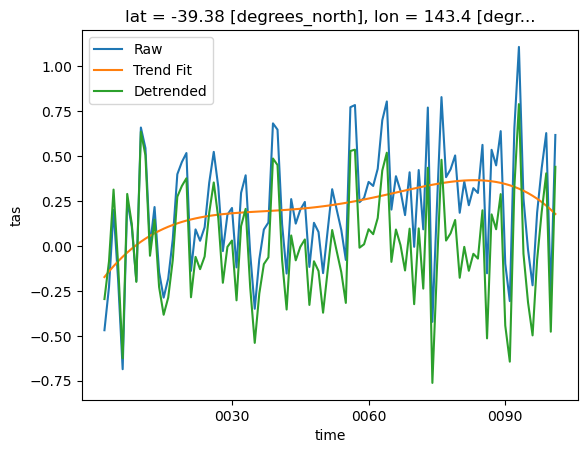

In [50]:
model = 'UKESM1-0-LL'#'CESM2'
a1_anom_data.sel(model=model).sel(lat=-39, lon=144, method='nearest').plot(label='Raw')
a1_anom_trend_data.sel(model=model).sel(lat=-39, lon=144, method='nearest').plot(label='Trend Fit')
a1_anom_detrend_data.sel(model=model).sel(lat=-39, lon=144, method='nearest').plot(label='Detrended')
plt.legend()

In [51]:
windows = np.arange(**constants.ZECMIP_MULTI_WINDOW_PARAMS)
windows

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

In [52]:
chunk_sizes = {'time':-1, 'model':1, 'window':10, 'lat':-1, 'lon':-1}

In [53]:
A1_FILE_PATH = os.path.join(constants.ZECMIP_STABILISATION_DIR, 'sn_ratio_a1_data')
PI_BOUNDS_FILE_PATH = os.path.join(constants.ZECMIP_STABILISATION_DIR, 'sn_ratio_bounds_p99_data')

In [54]:
if isinstance(a1_anom_data, (xr.Dataset, xr.DataArray)):
    A1_FILE_PATH = A1_FILE_PATH.replace('_data', '.zarr')
    PI_BOUNDS_FILE_PATH =  PI_BOUNDS_FILE_PATH.replace('_data', '.zarr')
else:
    A1_FILE_PATH = A1_FILE_PATH.replace('_data', '_xrlist')
    PI_BOUNDS_FILE_PATH =  PI_BOUNDS_FILE_PATH.replace('_data', '_xrlist')

In [55]:
A1_FILE_PATH, PI_BOUNDS_FILE_PATH

('/g/data/w40/ab2313/zecmip_stabilisation/sn_ratio_a1_xrlist',
 '/g/data/w40/ab2313/zecmip_stabilisation/sn_ratio_bounds_p99_xrlist')

In [56]:
# Using dask.delayed in several functions below. Scaling the workds
# to match the number of windows - as the calculation for each window will be sent off to a
# a new worker.
client.cluster.scale(18)#len(windows))
sleep(7) # The client cluster scale runs in the backgroud. Doing this let it finish here

-         Start Nanny at: 'tcp://127.0.0.1:33631'
-         Start Nanny at: 'tcp://127.0.0.1:39555'
-         Start Nanny at: 'tcp://127.0.0.1:39279'
-         Start Nanny at: 'tcp://127.0.0.1:44939'
-         Start Nanny at: 'tcp://127.0.0.1:36691'
-         Start Nanny at: 'tcp://127.0.0.1:36077'


In [57]:
# %%time

# # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
# sn_ratio_a1_data =\
#     a1_anom_data(sn_calc.signal_to_noise_ratio_multi_window,
#     # sn_calc.signal_to_noise_ratio_multi_window(a1_anom_data,
#     windows,
#     detrended_data=a1_anom_detrend_data,
#     parallel=True,
#     logginglevel='INFO'
# )
# sn_ratio_a1_data = sn_ratio_a1_data.drop('ensemble')
# sn_ratio_a1_data.name = 'sn'
# sn_ratio_a1_data = sn_ratio_a1_data.chunk(chunks=chunk_sizes)

# sn_ratio_a1_data.to_netcdf(A1_FILE_PATH, mode='w')

In [58]:
# sn_ratio_a1_data.to_netcdf(A1_FILE_PATH)

In [ ]:
# XRLIST
sn_ratio_bounds_data = esmpi_data(
    sn_calc.signal_to_noise_ratio_bounds_multi_window,
    windows, parallel_call=True, logginglevel='INFO')

- <function signal_to_noise_ratio_bounds_multi_window at 0x14ad37403be0> has been called
- parallel_call=True
- ACCESS-ESM1-5
- CESM2
- CanESM5
- GFDL-ESM4
- GISS-E2-1-G-CC
- MIROC-ES2L
- MPI-ESM1-2-LR
- NorESM2-LM
- UKESM1-0-LL


In [ ]:
# print(PI_BOUNDS_FILE_PATH)
# sn_ratio_bounds_data.to_netcdf(PI_BOUNDS_FILE_PATH)

In [ ]:
# %%time
# XARRAY
# # The S/N ratio for the control period.
# sn_ratio_bounds_data =\
#     sn_calc.multi_window_func_with_model_split(
#     sn_calc.signal_to_noise_ratio_bounds,
#     esmpi_data,
#     windows,
#     logginglevel='DEBUG'
# )



In [ ]:
sn_ratio_bounds_data.to_zarr(PI_BOUNDS_FILE_PATH, mode='w')

In [63]:
# Later code gets funky if there are too many workers
client.cluster.scale(12)
sleep(5) # The client cluster scale runs in the backgroud. Doing this let it finish here

In [64]:
sn_ratio_a1_data = read_listxarray(A1_FILE_PATH).sn

In [65]:
sn_ratio_bounds_data = read_listxarray(PI_BOUNDS_FILE_PATH,
                                          logginglevel='ERROR')

In [66]:
sn_ratio_a1_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'window': 31, 'model': 1, 'time': 90, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'window': 31, 'model': 1, 'time': 90, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'window': 31, 'model': 1, 'time': 90, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'window': 31, 'model': 1, 'time': 90, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'window': 31, 'model': 1, 'time': 90, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'window': 31, 'model': 1, 'time': 90, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'window': 31, 'model': 1, 'time': 90, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'window': 31, 'model': 1, 'time': 90, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'window': 31, 'model': 1, 'time': 90, 'lat': 144, 'lon': 192})

In [67]:
sn_ratio_bounds_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataSet : ['lower_bound', 'upper_bound']): ({'window': 31, 'model': 1, 'lat': 145, 'lon': 192})
CESM2          (dataSet : ['lower_bound', 'upper_bound']): ({'window': 31, 'model': 1, 'lat': 192, 'lon': 288})
CanESM5        (dataSet : ['lower_bound', 'upper_bound']): ({'window': 31, 'model': 1, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataSet : ['lower_bound', 'upper_bound']): ({'window': 31, 'model': 1, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataSet : ['lower_bound', 'upper_bound']): ({'window': 31, 'model': 1, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataSet : ['lower_bound', 'upper_bound']): ({'window': 31, 'model': 1, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataSet : ['lower_bound', 'upper_bound']): ({'window': 31, 'model': 1, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataSet : ['lower_bound', 'upper_bound']): ({'window': 31, 'model': 1, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataSet : ['lower_bound', 'upper_bound']): ({'window': 31,

In [68]:
# Open both the files. 
# This takes ages to run - so files have been saved
# sn_ratio_a1_data = xr.open_dataarray(A1_FILE_PATH, engine='zarr', chunks=chunk_sizes)
# sn_ratio_bounds_data = xr.open_dataset(PI_BOUNDS_FILE_PATH,engine='zarr')

In [69]:
sn_ratio_bounds_data.window #.values

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

In [70]:
sn_ratio_a1_data = sn_ratio_a1_data.drop('ensemble')
sn_ratio_bounds_data = sn_ratio_bounds_data.drop('ensemble')

In [71]:
max_effective_length = 60 #len(sn_ratio_a1_data.time.values) -  40
max_effective_length

60

In [72]:
sn_ratio_a1_data = sn_ratio_a1_data.isel(time=slice(None, max_effective_length))#.compute()

In [73]:
# The S/N ratio that is unstable - e.g. the A1 S/N where the pi-control is unstable
unstable_sn_data = sn_ratio_a1_data.where(
    (sn_ratio_a1_data>sn_ratio_bounds_data.upper_bound) | # Greater than upper-bounds
    (sn_ratio_a1_data<sn_ratio_bounds_data.lower_bound))# Less than lower bound

unstable_sn_data = unstable_sn_data.transpose(*['window', 'time', 'model', 'lat', 'lon'])

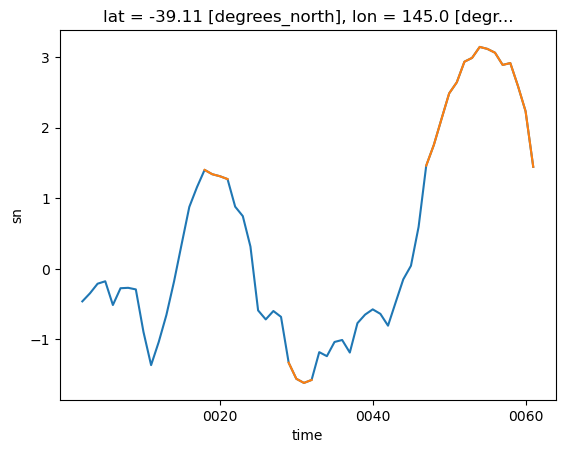

In [74]:
sn_ratio_a1_data[1].sel(window=31).sel(lat=-39, lon=145, method='nearest').plot()
unstable_sn_data[1].sel(window=31).sel(lat=-39, lon=145, method='nearest').plot()

In [75]:
# Just where the S/N ratio is stable. This is just the inverse of the above dataset
# is an easier way of doing this.
# stable_sn_data = xr.where(np.isnan(unstable_sn_data), sn_ratio_a1_data, np.nan)

In [76]:
unstable_sn_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 144, 'lon': 192})

# Stable Year Detection
This method use when all windows lengths become stable. The method then finds which window lengths are the windows that are unstable, and get the last unstable point in these windows

## Original

In [77]:
# Get the year that stabilisation occurs

# Note: NOt sure why, but if this isn't done in two parts, this returns a tranpose error.
year_stable_kwargs = dict(
    input_core_dims=[['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float]
)

year_stable_all_window_data = apply_ufunc( #xr
    sn_calc.find_stability_index,
    unstable_sn_data.chunk({'window':1, 'model':1}),
    unstable_sn_data[0].window,
    **year_stable_kwargs
).compute()


In [78]:
year_stable_data_original = year_stable_all_window_data.max(dim='window')

## New Method

In [89]:
reload(sn_calc)

<module 'signal_to_noise_calculations' from '/home/563/ab2313/Documents/zecmip_stabilisation/src/signal_to_noise_calculations.py'>

In [81]:
windows = unstable_sn_data[0].window.values

In [82]:
calcuate_year_stable_and_unstable = partial(sn_calc.calcuate_year_stable_and_unstable, windows=windows)

In [83]:
unstable_sn_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 144, 'lon': 192})

In [84]:
dim_order = ['time', 'window' , 'model', 'lat', 'lon']
dim_order

['time', 'window', 'model', 'lat', 'lon']

In [107]:
# td = xr.apply_ufunc(
#     sn_calc.calcuate_year_stable_and_unstable,
#     (unstable_sn_data[0]
#      .transpose(*dim_order)
#      .chunk({'time':-1, 'window':-1, 'lat':int(150/2), 'lon':int(192/2)})
#      # .isel(lat=slice(0,30), lon=slice(0,100))
#     ),
#     input_core_dims=[['time', 'window']],
#     output_core_dims=[['stability_index']],
#     dask_gufunc_kwargs={'output_sizes': {'stability_index': 9}},
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[np.float64],
#     kwargs = {'windows': windows, 'number_attempts':9, 'logginglevel':'INFO'}
# )#.compute()
# # td = td.compute()

In [108]:
year_stable_unstable_data_raw = apply_ufunc(
    sn_calc.calcuate_year_stable_and_unstable,
    unstable_sn_data.transpose(*dim_order).chunk({'time':-1, 'window':-1, 'lat':int(150/2), 'lon':int(200/2)}),
    input_core_dims=[['time', 'window']],
    output_core_dims=[['stability_index']],
    dask_gufunc_kwargs={'output_sizes': {'stability_index': 9}},
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float64],
    kwargs = {'windows': windows, 'number_attempts':9, 'logginglevel':'INFO'}
).compute()


In [109]:
unstable_sn_data[0]

<xarray.DataArray 'sn' (window: 31, time: 60, model: 1, lat: 145, lon: 192)> Size: 414MB
nan nan nan nan nan nan nan ... -2.471 -2.471 -2.471 -2.471 -2.471 -2.471 -2.471
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * model    (model) <U13 52B 'ACCESS-ESM1-5'
  * time     (time) object 480B 0001-12-31 00:00:00 ... 0060-12-31 00:00:00
  * window   (window) int64 248B 10 11 12 13 14 15 16 ... 34 35 36 37 38 39 40

In [ ]:
# year_stable_unstable_data_raw = year_stable_unstable_data_raw.compute()

In [111]:
year_stable_unstable_list = []
for model, ds in year_stable_unstable_data_raw:
    ds=ds.assign_coords(stability_index=[1, 2, 3, 4, 5, 6, 7, 8, 9])
    
    ds.attrs['Stability index'] ='Odd values mean stable, even mean unstable'
    year_stable_unstable_list.append(ds)

year_stable_unstable_data = listXarray(year_stable_unstable_list,'model')

In [112]:
np.unique(year_stable_unstable_data[0].sel(stability_index=1).values)

array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

In [113]:
year_stable_unstable_data[0].sel(lat=75, lon=75, method='nearest')

<xarray.DataArray 'sn' (model: 1, stability_index: 9)> Size: 72B
0.0 22.0 50.0 nan nan nan nan nan nan
Coordinates:
    lat              float64 8B 75.0
    lon              float64 8B 75.0
  * model            (model) <U13 52B 'ACCESS-ESM1-5'
  * stability_index  (stability_index) int64 72B 1 2 3 4 5 6 7 8 9
Attributes:
    Stability index:  Odd values mean stable, even mean unstable

In [114]:
year_stable_unstable_data[0].sel(lat=-77.5, lon=7.5, method='nearest')#.plot(y='window')

<xarray.DataArray 'sn' (model: 1, stability_index: 9)> Size: 72B
0.0 0.0 7.0 nan nan nan nan nan nan
Coordinates:
    lat              float64 8B -77.5
    lon              float64 8B 7.5
  * model            (model) <U13 52B 'ACCESS-ESM1-5'
  * stability_index  (stability_index) int64 72B 1 2 3 4 5 6 7 8 9
Attributes:
    Stability index:  Odd values mean stable, even mean unstable

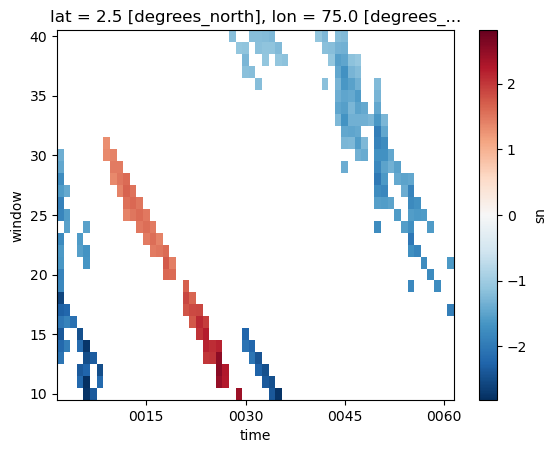

In [115]:
unstable_sn_data[0].sel(lat=2, lon=75, method='nearest').plot(y='window')

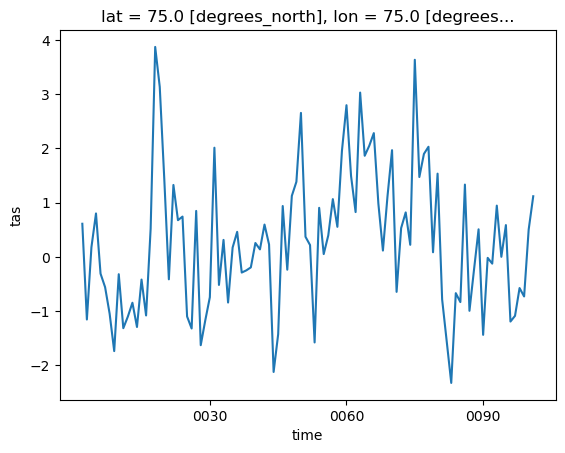

In [116]:
a1_anom_data[0].sel(lat=75, lon=75, method='nearest').plot()

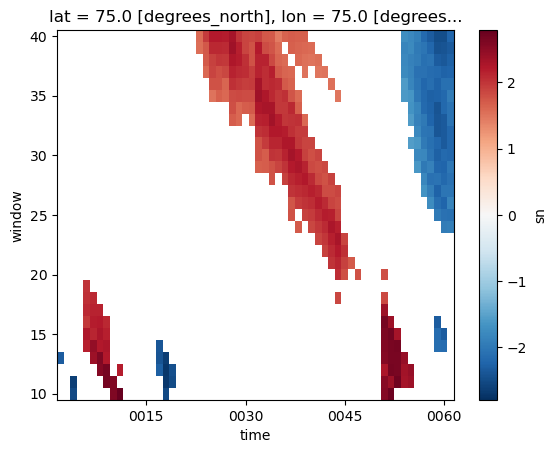

In [117]:
unstable_sn_data[0].sel(lat=75, lon=75, method='nearest').plot(y='window')

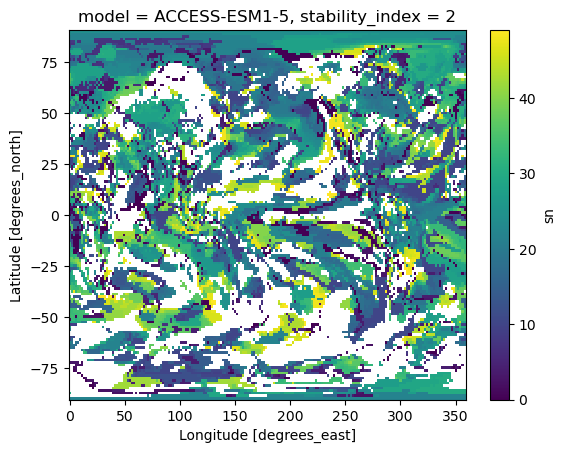

In [118]:
year_stable_unstable_data[0].sel(stability_index=2).plot()

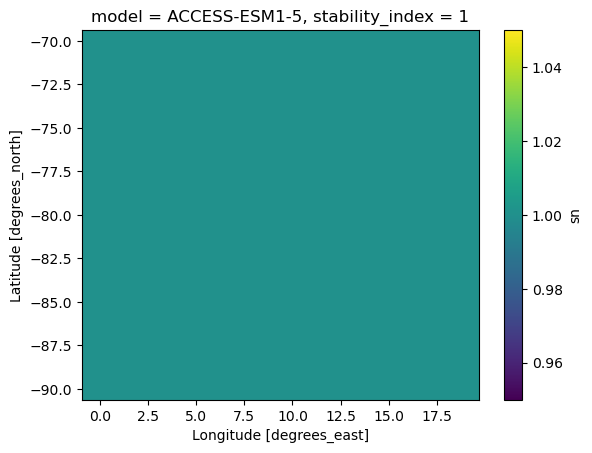

In [119]:
xr.where(np.isfinite(year_stable_unstable_data[0].sel(stability_index=1)), 1, 0).sel(lat=slice(-90, -70), lon=slice(0, 20)).plot()

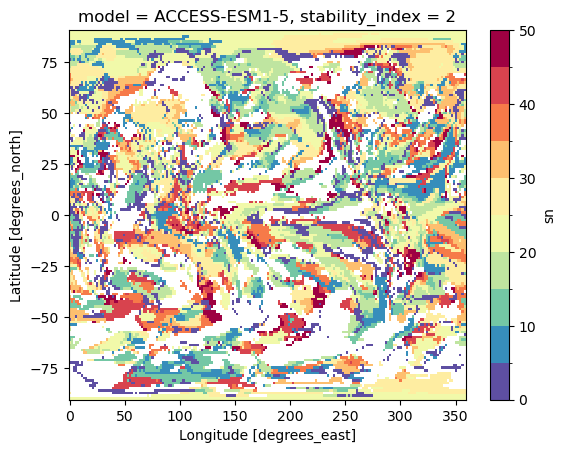

In [120]:
year_stable_unstable_data[0].sel(stability_index=2).plot(levels=np.linspace(0, 50.0001, num=11), 
                                                         cmap='Spectral_r')

In [179]:
less_than_zero_diff = where(
    (year_stable_unstable_data.sel(stability_index=1)-\
     year_stable_unstable_data.sel(stability_index=2))<0, 1, 0)

In [195]:
year_stable_unstable_data[0].sel(lat=-72.5, lon=2.5, method='nearest').values

array([[ 0.,  3., 13., nan, nan, nan, nan, nan, nan]])

In [217]:
tarr = unstable_sn_data[0].sel(lat=-72.5, lon=2.5, method='nearest').squeeze().values
tarr = np.where(np.isfinite(tarr), 1, 0)
tarr.shape

(31, 60)

In [230]:
farr = np.where(sn_calc.frac_non_zero_window(tarr.transpose(-1, 0), windows=windows)>=0.5, 1, 0)
farr.shape

(60, 31)

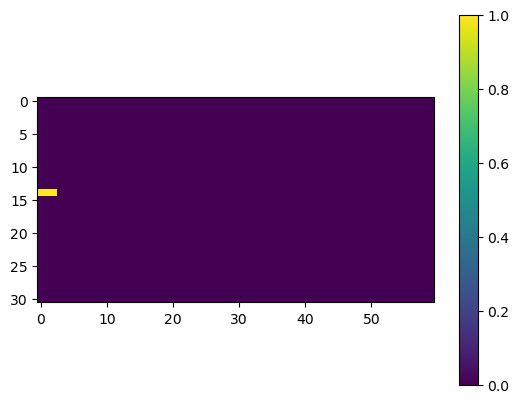

In [231]:
plt.imshow(farr.transpose(-1, 0))#, vmax=1)#, levels=np.arange(0,1.25, 0.25))
plt.colorbar()

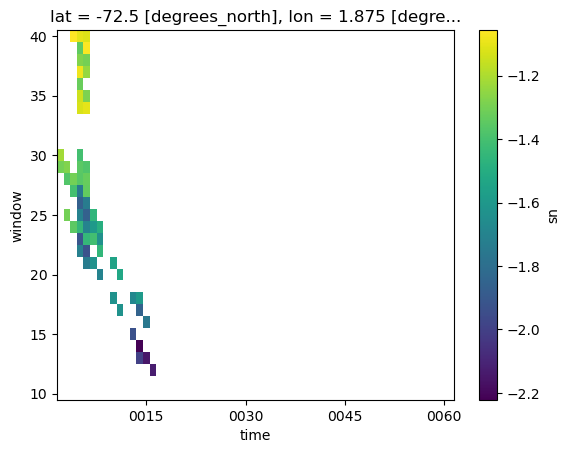

In [196]:
unstable_sn_data[0].sel(lat=-72.5, lon=2.5, method='nearest').plot()

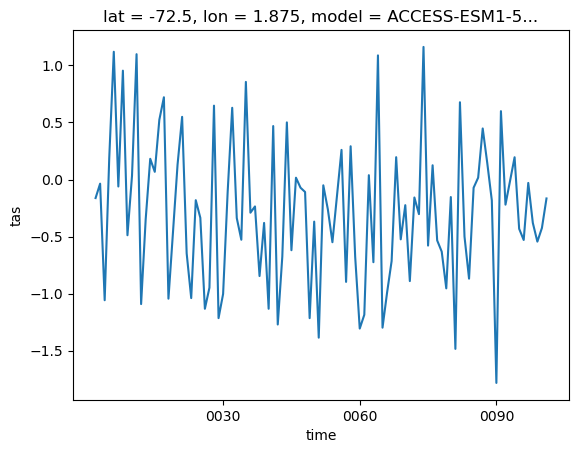

In [192]:
a1_anom_data[0].sel(lat=-72.5, lon=2.5, method='nearest').plot()

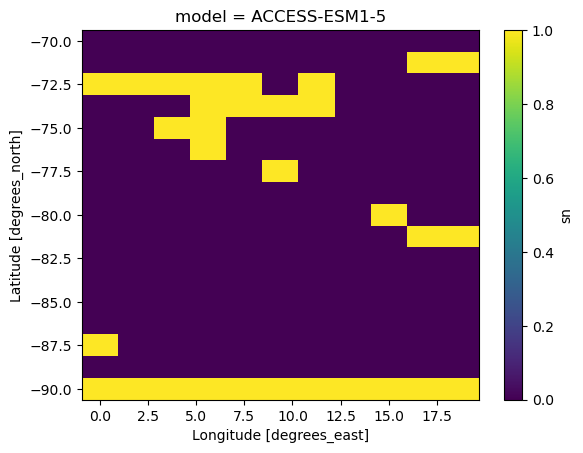

In [191]:
less_than_zero_diff[0].sel(lat=slice(-90, -70), lon=slice(0, 20)).plot()

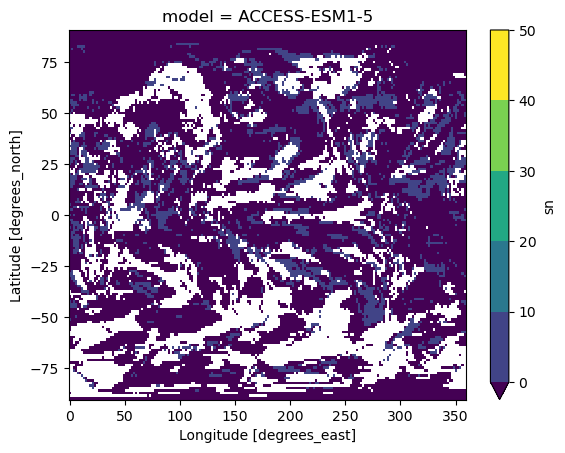

In [174]:
(year_stable_unstable_data[0].sel(stability_index=1)-\
   year_stable_unstable_data[0].sel(stability_index=2)).plot(levels=np.linspace(0, 50.01, num=6))

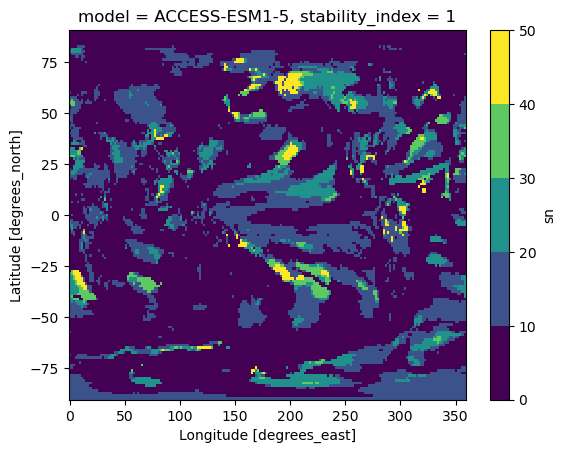

In [122]:
year_stable_unstable_data[0].sel(stability_index=1).plot(levels=np.linspace(0, 50.01, num=6))

# Stable Anomalies

In [123]:
year_stable_data = year_stable_unstable_data.sel(stability_index=1)#total_stable_year_data#year_stable_data_original

In [124]:
# Get the 20-year average tempeature anomaly at stabilisation.
stable_anom_da = apply_ufunc( #xr.
    sn_calc.get_average_after_stable_year,
    a1_anom_data,
    year_stable_data,
    input_core_dims=[['time'],[]],
    output_core_dims=[[]],
    output_dtypes=[np.float],
    vectorize=True
)

In [125]:
stable_anom_da

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'model': 1, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'model': 1, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'model': 1, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'model': 1, 'lat': 144, 'lon': 192})

# Region Percent Stable Time series

In [126]:
class Region(NamedTuple):
    name: str
    slice: tuple

class regionLatLonTuples(Enum):
    GLOBAL = Region('gl', slice(None, None))
    LAND = Region('land', slice(None, None))
    OCEAN = Region('ocean', slice(None, None))
    NH = Region('nh', slice(0, None))
    SH = Region('sh', slice(None, 0))
    TROPICS = Region('tropics', slice(-23, 23))
    MID_LAT_SH = Region('mid_sh', slice(-66, -23))
    MID_LAT_NH = Region('mid_nh', slice(23, 66))
    ARCTIC = Region('arctic', slice(66, None))
    ANTARCTIC = Region('antarctic', slice(None, -66))


NAMING_MAP = {
    'global': 'Global',
    'nh': 'Northern Hemisphere',
    'sh': 'Southern Hemisphere',
    'tropics': 'Tropics',
    'land': 'Land',
    'ocean': 'Ocean',
    'mid_nh': 'Mid Latitudes NH',
    'mid_sh': 'Mid Latitudes SH',
    'arctic': 'Arctic',
    'antarctic': 'Antarctic'}

In [127]:
def fraction_comparison(ds_num, ds_denom, weights):
    """
    Calculate the percentage by comparing two datasets.

    Parameters:
        ds_num (xarray.Dataset): Numerator dataset.
        ds_denom (xarray.Dataset): Denominator dataset.
        weights (xarray.DataArray): Weights for the calculation.

    Returns:
        xarray.DataArray: Dataset containing the percentage.
    """
    # Calculate the sum of the numerator dataset weighted by weights
    ds_num_sum = ds_num.weighted(weights).sum(dim=['lat', 'lon'])

    # Calculate the sum of the denominator dataset weighted by weights
    ds_denom_sum = ds_denom.weighted(weights).sum(dim=['lat', 'lon'])

    # Calculate the percentage
    percent_data = ds_num_sum / ds_denom_sum * 100

    return percent_data

In [128]:
def calculate_returned_binary_data(arr: ArrayLike, year_of_emergence: int, time_years: ArrayLike) -> ArrayLike:
    """
    Calculates a binary array representing the emergence of an event.

    E.g. after stabilisation all values will be 1, whilst before stabilisation
    all years will be 0

    Parameters:
        arr (ArrayLike): Input array.
        year_of_emergence (int): Year of the event's emergence.
        time_years (ArrayLike): Array of years.

    Returns:
        ArrayLike: Binary array representing the event's emergence.
                   0 before the year_of_emergence, 1 after.

    If year_of_emergence is NaN or all values in arr are NaN, the function
    returns arr unchanged.
    """

    #print(arr.shape, year_of_emergence, end='')
    # If the year_of_emergence is nan or all the values at the location are nan
    # then return nan
    if np.isnan(year_of_emergence): return arr

    # The integer arguement of where the time_years equals the emergence arg
    emergence_arg = np.argwhere(time_years == np.round(year_of_emergence))
    
    if len(emergence_arg) == 0:
        return np.nan
    if isinstance(emergence_arg, int): pass
    elif emergence_arg.shape == (1,1): emergence_arg = emergence_arg.item()
    
    to_return = np.zeros_like(arr)
    
    # Set all values to 1 after emergence has occured
    to_return[emergence_arg:] =  1

    return to_return

In [129]:
def create_regions(binary_emergence_data: xr.Dataset, land_mask_data:xr.Dataset) -> xr.Dataset:
    """
    Calculate the percentage of stability for regions based on binary emergence data.

    Parameters:
        binary_emergence_data (xr.Dataset): Dataset containing binary emergence data.
        land_mask_data (xr.Dataset): Dataset containing land mask data.
        only_1s_data (xr.Dataset): Dataset with only values of 1. This is needed as it can differ
                                due to data availability

    Returns:
        xr.Dataset: Dataset with percentage of stability for each region.

    This function calculates the percentage of stability for regions based on binary
    emergence data and land mask information. It assumes the existence of a variable
    'only_1s_data' that is the same shape as 'binary_emergence_data' and contains only
    values of 1 where the event has occurred.
    """

    # Calculating the weights
    weights = np.cos(np.deg2rad(binary_emergence_data.lat))
    weights.name = 'weights'

    # The two regions that need the land-sea make
    NEEDS_MASKING = ['land', 'ocean']

    ds_collection = [] # Storing all the datasets
    points_in_region_dict = {} # The number of 
    for region in regionLatLonTuples:
        region_name = region.value.name.lower()
        lat_slice = region.value.slice
        
        # Select data for the current region
        ds_region = binary_emergence_data.sel(lat=lat_slice).expand_dims({'region':[region_name]})

        # Apply masking if needed
        if region_name in NEEDS_MASKING:
            mask_to_use_data = xr.where(land_mask_data, 1, 0) if region_name == 'land' else xr.where(land_mask_data, 0, 1) 
            ds_region = ds_region.where(mask_to_use_data)


        ds_collection.append(ds_region)

    ds_regions = xr.concat(ds_collection, dim='region')

    return ds_regions

In [130]:
mask_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'model': 1, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'model': 1, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'model': 1, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'model': 1, 'lat': 144, 'lon': 192})

In [322]:
weight_list = []
for model in mask_data.model:
    weights = np.cos(np.deg2rad(mask_data[model].lat))
    weight_list.append(weights.expand_dims(model=[model]))
weight_data = listXarray(weight_list, mask_data.key_dim)
weight_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'lat': 145})
CESM2          (dataArray): ({'model': 1, 'lat': 192})
CanESM5        (dataArray): ({'model': 1, 'lat': 64})
GFDL-ESM4      (dataArray): ({'model': 1, 'lat': 180})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'lat': 90})
MIROC-ES2L     (dataArray): ({'model': 1, 'lat': 64})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'lat': 96})
NorESM2-LM     (dataArray): ({'model': 1, 'lat': 96})
UKESM1-0-LL    (dataArray): ({'model': 1, 'lat': 144})

In [132]:
def binary_stable_unstable_assignment(year_list):
    '''
    Assigning 1 for unstable and 0 for stable

    The first value in 'year_list' is the year at which stability occurs
    The second value is the year at which instability occurs
    '''

    end_point = int(np.nanmax(year_list))
    
    
    binary_stability_list = []
    for num in range(len(year_list)):
        
        # print(year)
        if np.isnan(year_list[num]):
            break


        
        if num == 0:
            tile_length = year_list[num]
        else:
            tile_length = year_list[num] - year_list[num-1]
            
        tile_length = int(tile_length)
        fill_val = 1 - (num % 2) # 0 -> 1, 1->0, 2->1

        number_vals = np.tile(fill_val, tile_length)
        binary_stability_list.append(number_vals)
        
    return np.concatenate(binary_stability_list)
        

In [238]:
def binary_stable_unstable_assignment(year_list, expected_length=50):
    '''
    Assigning 1 for unstable and 0 for stable.

    The first value in 'year_list' is the year at which stability occurs.
    The second value is the year at which instability occurs.
    '''
    
    # Remove any NaN values from year_list and get the maximum year
    year_list = np.array(year_list)
    valid_years = year_list[~np.isnan(year_list)]

    # Need to make sure this finishes at 50
    # E.g if the climate stabilises at the year 13, then only 13 ones 
    # between the year 0 and 13 are applied
    if not np.any(a>=expected_length):
        year_list = np.concatenate([year_list, [expected_length]])

    end_point = int(np.nanmax(year_list))
    
    # Initialize the binary stability list, start with ones (unstable)
    binary_stability_list = np.ones(end_point)
    
    # Assign 0s for stable periods
    for i in range(0, len(valid_years), 2):
        start = int(valid_years[i])
        end = int(valid_years[i + 1]) if i + 1 < len(valid_years) else end_point
        binary_stability_list[start:end] = 0

    if len(binary_stability_list) < expected_length:
        binary_stability_list = np.concatenate([binary_stability_list, np.tile(np.nan, expected_length-len(binary_stability_list))])
    
    return binary_stability_list


In [240]:
binary_stability_stable_unstable_data = apply_ufunc(
    binary_stable_unstable_assignment,
    year_stable_unstable_data,
    input_core_dims=[['stability_index']],
    output_core_dims=[['time']],
    vectorize=True,
    dask_gufunc_kwargs = {'output_sizes':{'time':50}}
)

In [241]:
binary_stability_stable_unstable_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'lat': 145, 'lon': 192, 'time': 50})
CESM2          (dataArray): ({'model': 1, 'lat': 192, 'lon': 288, 'time': 50})
CanESM5        (dataArray): ({'model': 1, 'lat': 64, 'lon': 128, 'time': 50})
GFDL-ESM4      (dataArray): ({'model': 1, 'lat': 180, 'lon': 288, 'time': 50})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'lat': 90, 'lon': 144, 'time': 50})
MIROC-ES2L     (dataArray): ({'model': 1, 'lat': 64, 'lon': 128, 'time': 50})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'lat': 96, 'lon': 192, 'time': 50})
NorESM2-LM     (dataArray): ({'model': 1, 'lat': 96, 'lon': 144, 'time': 50})
UKESM1-0-LL    (dataArray): ({'model': 1, 'lat': 144, 'lon': 192, 'time': 50})

In [293]:
unstable_sn_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'window': 31, 'time': 60, 'model': 1, 'lat': 144, 'lon': 192})

In [302]:
year_stable_unstable_data[0].sel(stability_index=1).sel(lat=-67.5, lon=220, method='nearest').values#.plot()

array([0.])

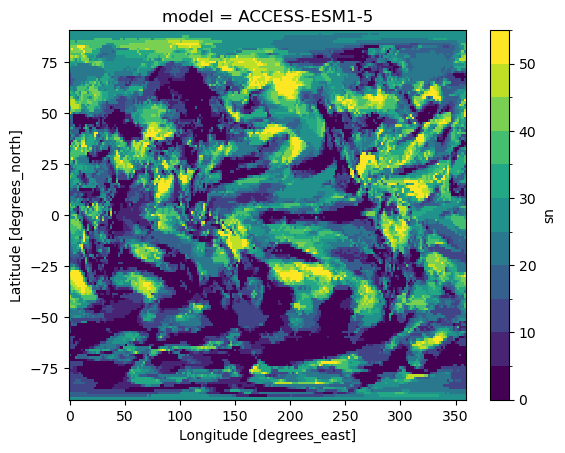

In [292]:
(binary_stability_stable_unstable_data[0].sum(dim='time')).plot(levels=np.arange(0,55.1,5))

In [256]:
# # Using the year when each window becomes stable. Create a data set that is
# # 0 when unstable and 1 when stable. 
# binary_stability_da = xr.apply_ufunc( #xr
#     calculate_returned_binary_data,
#     unstable_sn_data[2].isel(window=0), # This is just a place holder, used for the shape
#     xr.where(year_stable_data[2]>50, 50, year_stable_data[1]),
#     unstable_sn_data[2].time.dt.year-1, # Subtracting one, as this is ofset by 1
#     input_core_dims = [['time'], [], ['time']],
#     output_core_dims=[['time']],
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[np.float64]
# ).compute()

In [160]:
# # Using the year when each window becomes stable. Create a data set that is
# # 0 when unstable and 1 when stable. 
# binary_stability_data = apply_ufunc( #xr
#     calculate_returned_binary_data,
#     unstable_sn_data.isel(window=0), # This is just a place holder, used for the shape
#     where(year_stable_data>50, 50, year_stable_data),
#     unstable_sn_data[0].time.dt.year-1, # Subtracting one, as this is ofset by 1
#     input_core_dims = [['time'], [], ['time']],
#     output_core_dims=[['time']],
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[np.float64]

# ).compute()

In [257]:
binary_stability_data = binary_stability_stable_unstable_data

In [258]:
# import listXarray
# reload(listXarray)
# from listXarray import listXarray, where

In [259]:
# A dataset with every point as 1, this is useful for getting the maximum weighted sum for a field
# full_data = xr.where(np.isfinite(binary_stability_data), 1, 1)
full_data = where(binary_stability_data(np.isfinite), 1, 1).compute()

In [260]:
mask_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'model': 1, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'model': 1, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'model': 1, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'model': 1, 'lat': 144, 'lon': 192})

In [306]:
binary_stability_da

<xarray.DataArray 'sn' (model: 1, lat: 145, lon: 192, time: 50)> Size: 11MB
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * model    (model) <U13 52B 'ACCESS-ESM1-5'
Dimensions without coordinates: time

In [307]:
mask_da

<xarray.DataArray (model: 1, lat: 145, lon: 192)> Size: 223kB
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Coordinates:
  * model    (model) object 8B 'ACCESS-ESM1-5'
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Attributes:
    regrid_method:  nearest_s2d

In [315]:
binary_stability_data_regions_list = []
for model in binary_stability_data.model:
    binary_stability_da = binary_stability_data.sel(model=model)
    mask_da = mask_data.sel(model=model)
    binary_stability_da_regions = create_regions(binary_stability_da, mask_da)
    binary_stability_data_regions_list.append(binary_stability_da_regions)
binary_stability_data_regions = listXarray(binary_stability_data_regions_list, 'model')

In [317]:
binary_stability_data_regions

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'region': 10, 'model': 1, 'lat': 145, 'lon': 192, 'time': 50})
CESM2          (dataArray): ({'region': 10, 'model': 1, 'lat': 192, 'lon': 288, 'time': 50})
CanESM5        (dataArray): ({'region': 10, 'model': 1, 'lat': 64, 'lon': 128, 'time': 50})
GFDL-ESM4      (dataArray): ({'region': 10, 'model': 1, 'lat': 180, 'lon': 288, 'time': 50})
GISS-E2-1-G-CC (dataArray): ({'region': 10, 'model': 1, 'lat': 90, 'lon': 144, 'time': 50})
MIROC-ES2L     (dataArray): ({'region': 10, 'model': 1, 'lat': 64, 'lon': 128, 'time': 50})
MPI-ESM1-2-LR  (dataArray): ({'region': 10, 'model': 1, 'lat': 96, 'lon': 192, 'time': 50})
NorESM2-LM     (dataArray): ({'region': 10, 'model': 1, 'lat': 96, 'lon': 144, 'time': 50})
UKESM1-0-LL    (dataArray): ({'region': 10, 'model': 1, 'lat': 144, 'lon': 192, 'time': 50})

In [316]:
# binary_stability_data_regions = binary_stability_data(create_regions, mask_data).compute()

In [318]:
full_data_regions = full_data(create_regions,  mask_data).compute()

In [319]:
# binary_stability_data_regions['CESM2'].sum(dim=['lat', 'lon']).plot(hue='region')

In [320]:
# for model in binary_stability_data_regions.model:
#     region_model_ds = 
#     full_model_ds = 
#     fraction_model_ds = fraction_comparison(region_model_ds, full_model_ds, weights_model_ds)

In [323]:
percent_stable_timeseries_ds = binary_stability_data_regions(
    fraction_comparison, full_data_regions, weight_data).concat(dim='model').compute()

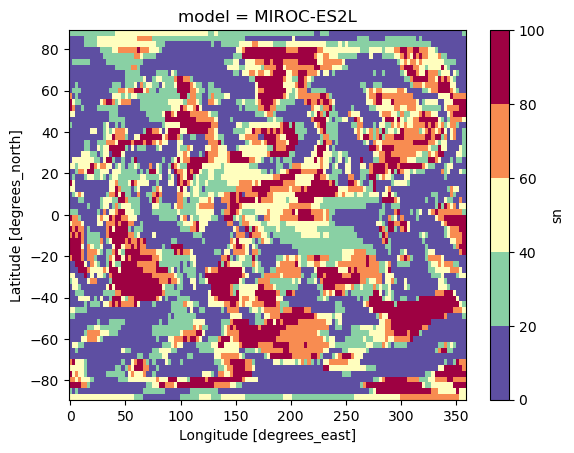

In [355]:
(binary_stability_data.sel(model='MIROC-ES2L').isel(time=slice(25, 50)).sum(dim='time')*100/25).plot(
    levels=np.linspace(0, 100.01, 6),  cmap='Spectral_r')

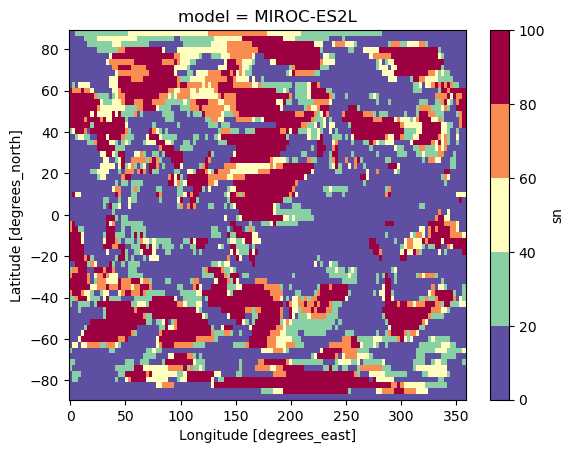

In [354]:
(binary_stability_data.sel(model='MIROC-ES2L').isel(time=slice(0, 25)).sum(dim='time')*100/25).plot(
    levels=np.linspace(0, 100.01, 6),  cmap='Spectral_r')

In [357]:
num_years_unstable = binary_stability_data.sel(model='MIROC-ES2L').sum(dim='time')

In [360]:
num_years_unstable

<xarray.DataArray 'sn' (model: 1, lat: 64, lon: 128)> Size: 66kB
14.0 14.0 14.0 14.0 14.0 14.0 14.0 14.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 6.0 11.0
Coordinates:
  * lat      (lat) float64 512B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * model    (model) <U10 40B 'MIROC-ES2L'

In [369]:
year_stable_unstable_data['MIROC-ES2L'].sel(lat=-10, lon=260, method='nearest')

<xarray.DataArray 'sn' (model: 1, stability_index: 9)> Size: 72B
0.0 42.0 50.0 nan nan nan nan nan nan
Coordinates:
    lat              float64 8B -9.767
    lon              float64 8B 258.8
  * model            (model) <U10 40B 'MIROC-ES2L'
  * stability_index  (stability_index) int64 72B 1 2 3 4 5 6 7 8 9
Attributes:
    Stability index:  Odd values mean stable, even mean unstable

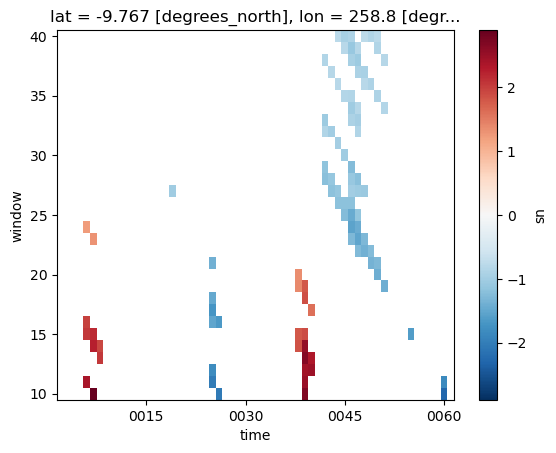

In [368]:
unstable_sn_data['MIROC-ES2L'].sel(lat=-10, lon=260, method='nearest').plot()

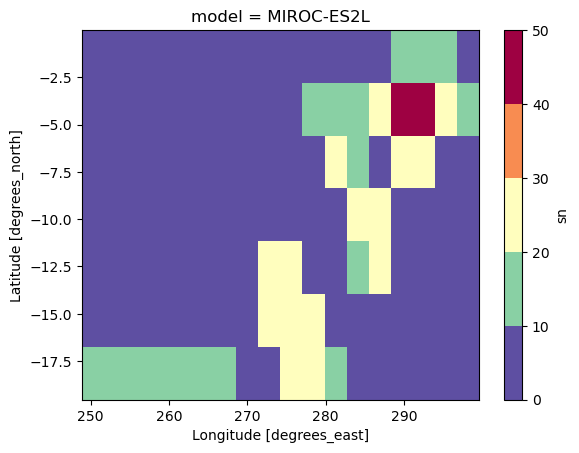

In [361]:
num_years_unstable.sel(lat=slice(-20, 0), lon=slice(250, 300)).plot(levels=np.linspace(0, 50.01, 6), cmap='Spectral_r')

In [372]:
year_stable_unstable_data['MIROC-ES2L'].sel(lat=10, lon=170, method='nearest')#.plot()

<xarray.DataArray 'sn' (model: 1, stability_index: 9)> Size: 72B
10.0 10.0 45.0 nan nan nan nan nan nan
Coordinates:
    lat              float64 8B 9.767
    lon              float64 8B 168.8
  * model            (model) <U10 40B 'MIROC-ES2L'
  * stability_index  (stability_index) int64 72B 1 2 3 4 5 6 7 8 9
Attributes:
    Stability index:  Odd values mean stable, even mean unstable

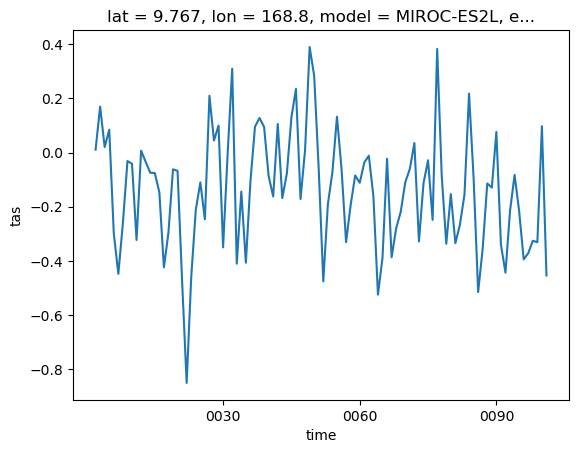

In [426]:
a1_anom_data['MIROC-ES2L'].sel(lat=10, lon=170, method='nearest').plot()

In [419]:
test_ds = unstable_sn_data['MIROC-ES2L'].sel(lat=10, lon=170, method='nearest').squeeze().transpose(*['time', 'window'])
test_arr = test_ds.values#.transpose(-1, 0)
test_arr = np.where(np.isfinite(test_arr), 1, 0)
test_arr.shape

(60, 31)

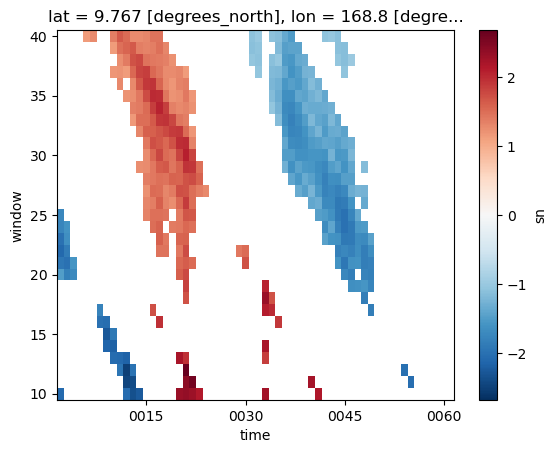

In [420]:
test_ds.plot(y='window')

In [421]:
time_length = test_arr.shape[0]
window_length = test_arr.shape[-1]
window_time_fracs = []
for w in range(window_length):
    time_fracs = []
    for t in range(time_length-10):
        time_arr = test_arr[t:t+10, w]
        frac = np.sum(time_arr)/10
        time_fracs.append(frac)
    window_time_fracs.append(np.array(time_fracs))
window_time_fracs = np.array(window_time_fracs)   

In [423]:
test_arr[:, w]

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

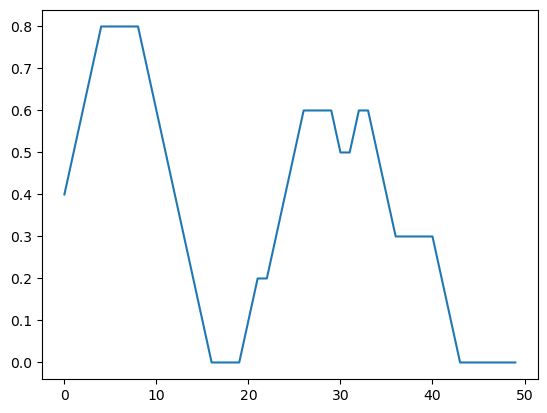

In [413]:
plt.plot(window_time_fracs[-1, :])

In [411]:
window_time_fracs.shape

(31, 50)

In [403]:
test_arr[:10, -1]

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1])

In [399]:
xr.where(empty_ds>0.5, 1, 0).sel(window=40).isel(time=slice(0, 10))

<xarray.DataArray 'sn' (time: 10)> Size: 80B
0 0 1 1 1 1 1 1 1 1
Coordinates:
    lat      float64 8B 9.767
    lon      float64 8B 168.8
    model    <U10 40B 'MIROC-ES2L'
  * time     (time) object 80B 0001-12-31 00:00:00 ... 0010-12-31 00:00:00
    window   int64 8B 40

In [400]:
empty_ds.sel(window=40).isel(time=slice(0, 10))

<xarray.DataArray 'sn' (time: 10)> Size: 80B
0.4 0.5 0.6 0.7 0.8 0.8 0.8 0.8 0.8 0.7
Coordinates:
    lat      float64 8B 9.767
    lon      float64 8B 168.8
    model    <U10 40B 'MIROC-ES2L'
  * time     (time) object 80B 0001-12-31 00:00:00 ... 0010-12-31 00:00:00
    window   int64 8B 40

In [401]:
test_arr.shape

(60, 31)

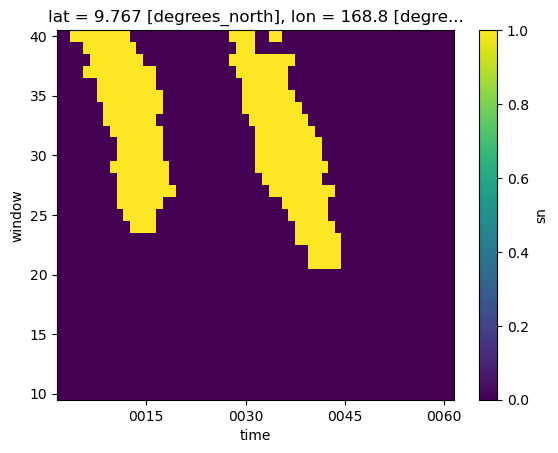

In [394]:
empty_ds = xr.zeros_like(test_ds)
farr =  sn_calc.frac_non_zero_window(test_arr, windows)
empty_ds += farr
xr.where(empty_ds>0.5, 1, 0).plot(y='window')

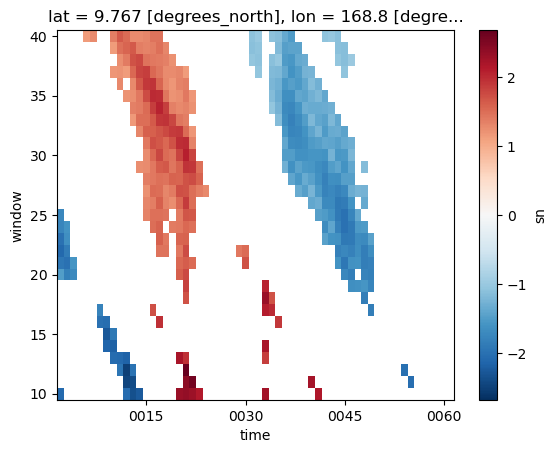

In [370]:
unstable_sn_data['MIROC-ES2L'].sel(lat=10, lon=170, method='nearest').plot()

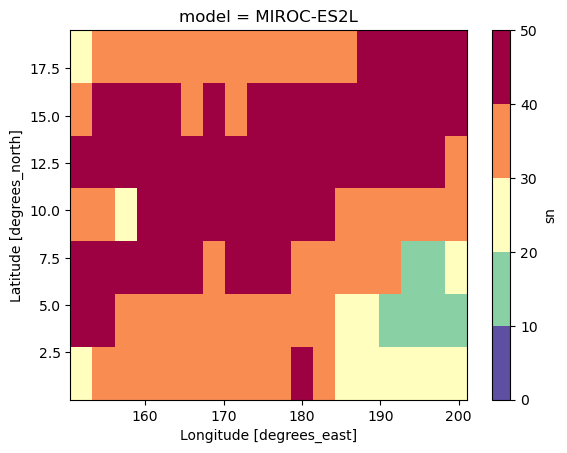

In [362]:
num_years_unstable.sel(lat=slice(0, 20), lon=slice(150, 200)).plot(levels=np.linspace(0, 50.01, 6), cmap='Spectral_r')

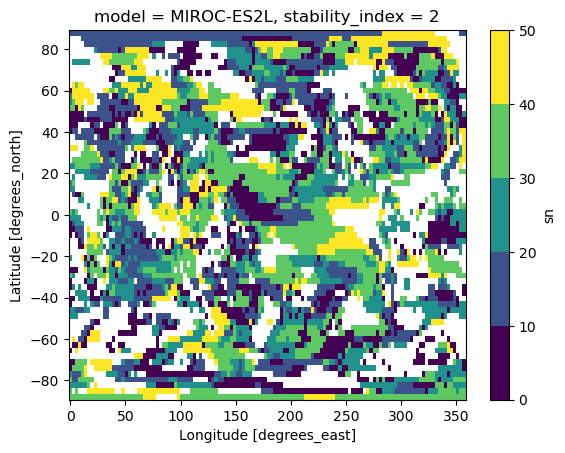

In [343]:
year_stable_unstable_data.sel(model='MIROC-ES2L').sel(stability_index=2).plot(levels=np.linspace(0, 50.01, 6))

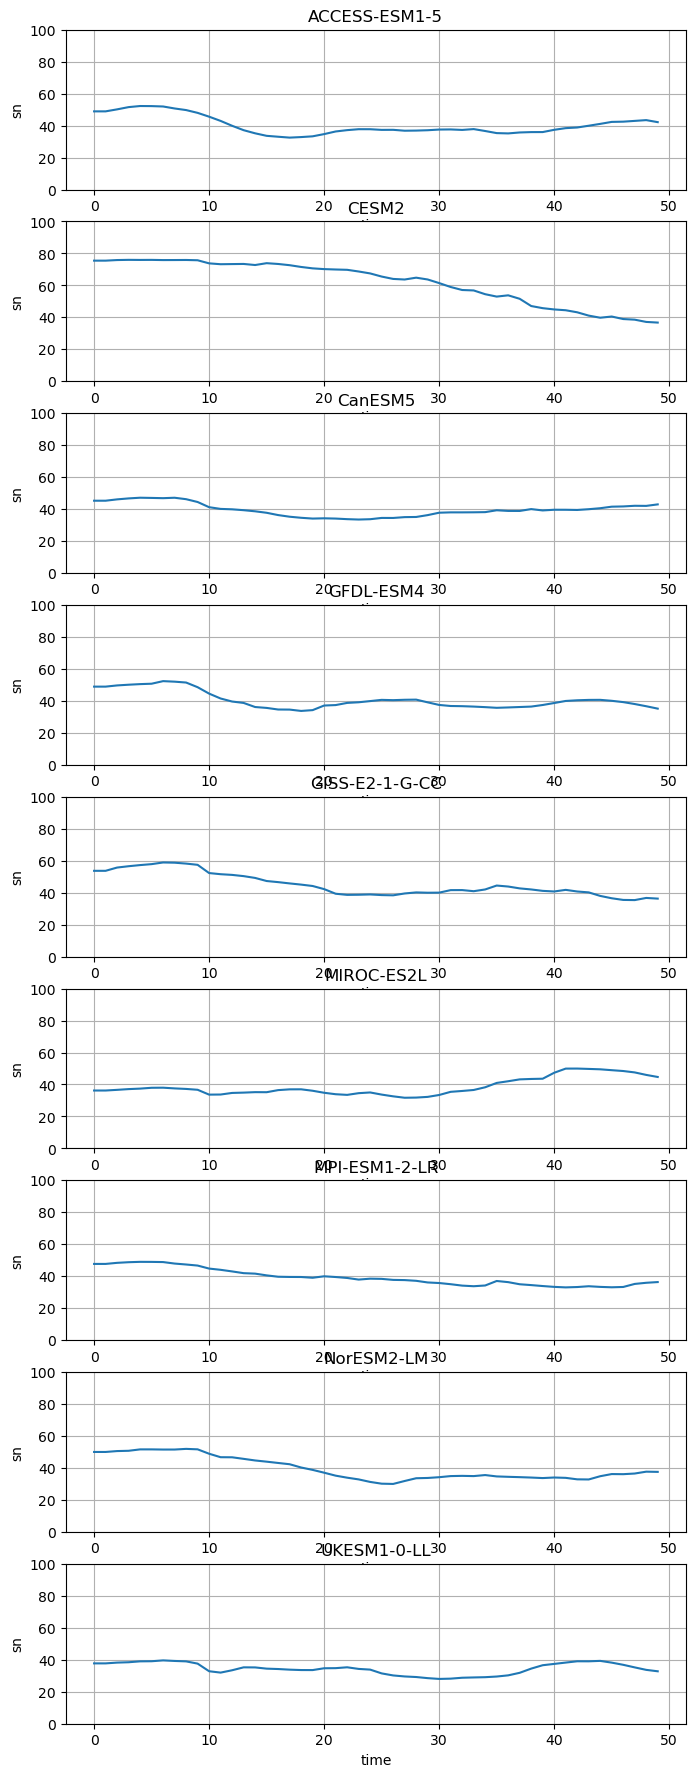

In [336]:
fig, axes = plt.subplots(9, 1, figsize=(8, 22))

for num,model in enumerate(percent_stable_timeseries_ds.model.values):
    ax = axes[num]
    percent_stable_timeseries_ds.sel(model=model, region='gl').plot(ax=ax)
    ax.set_ylim(0, 100)
    ax.grid()
    ax.set_title(model)

(0.0, 100.0)

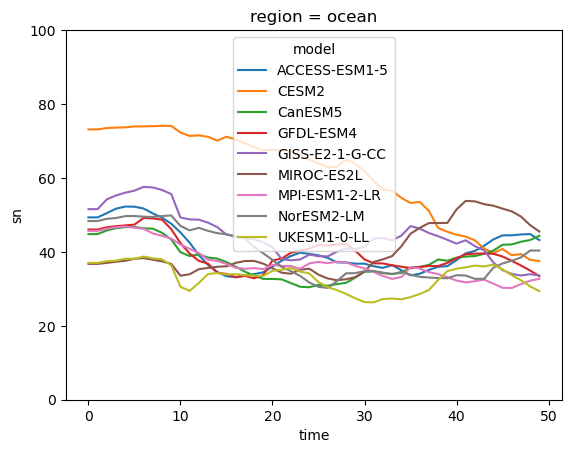

In [328]:
percent_stable_timeseries_ds.isel(region=2).plot(hue='model');
plt.ylim(0, 100)

In [ ]:
region_order = ['gl', 'nh', 'sh', 'land', 'ocean', 'arctic', 'antarctic', 'mid_nh', 'mid_sh', 'tropics']
percent_stable_timeseries_ds = percent_stable_timeseries_ds.sel(region=region_order)

In [ ]:
# percent_stable_timeseries_data = percent_stable_timeseries_data.compute()
# percent_stable_timeseries_data

In [ ]:
# Opposite of the above: Stable replace with 0n and unstable is 1.
# The opposite is need as we are looking at when the percetage of unstable points becomes 0
binary_unstable_data = where(binary_stability_data, 0, 1) #xr
binary_unstable_warm_data = binary_unstable_data.where(stable_anom_da>0)
binary_unstable_cool_data = binary_unstable_data.where(stable_anom_da<=0)

In [ ]:
# The number of cooling and warming trends at each grid cell
number_warm_data = binary_unstable_warm_data(fraction_comparison, full_data, weight_data)#.expand_dims(region=['global_warm']) 
number_cool_data = binary_unstable_cool_data(fraction_comparison, full_data, weight_data)#.expand_dims(region=['global_warm']) 

In [ ]:
number_cool_data = number_cool_data.compute().concat(dim='model').drop(['ensemble', 'window'])
number_warm_data = number_warm_data.compute().concat(dim='model').drop(['ensemble', 'window'])

In [ ]:
number_cool_data.plot(hue='model');

In [ ]:
# percent_stable_timeseries_ds = percent_stable_timeseries_data.concat(dim='model')
# percent_stable_timeseries_ds

In [ ]:
full_data_regions.isel(model=0).isel(time=1).plot(col='region', col_wrap=3)

In [ ]:
binary_stability_data_regions.isel(model=2).isel(time=1).plot(col='region', col_wrap=3)

# Quick Verification Plots
Plots that are not good, but nice to plot to check

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3,3)
axes =[fig.add_subplot(gs[i], projection=ccrs.PlateCarree()) for i in range(len(stable_anom_da))]

for num in range(len(stable_anom_da)):
    ax = axes[num]
    stable_anom_da[num].plot(ax=ax)
    ax.coastlines()
    ax.set_title(stable_anom_da.refkeys[num])

In [ ]:
stable_anom_da.isel(model=0).plot()

In [ ]:
# stable_anom_da.plot(col='model', col_wrap=3, robust=True)

In [ ]:
# year_stable_data.plot(col='model', col_wrap=3)

In [ ]:
unstable_sn_data[0]

In [ ]:
# unstable_sn_data.isel(window=-1, model=1, time=4).plot()

In [ ]:
# stable_anom_da.plot(col='model', col_wrap=3, robust=True)

In [ ]:
# stable_sn_data.isel(window=-1, model=1, time=4).plot()

In [ ]:
projection = ccrs.PlateCarree(central_longitude=np.mean(year_stable_data[0].lon.values))

In [ ]:
projection = ccrs.PlateCarree(central_longitude=-90)
# np.mean(rolling_year_stable_window_max_data.lon.values)-90

In [ ]:
# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
# year_stable_model_average.average_value.plot(ax=ax, cmap='BuPu')
# ax.coastlines()

In [ ]:
sn_ratio_a1_data

# Plots

## Set-up

In [145]:
# One projeciton for when it is to be passed into a function. The other is when I am using it here.
# The passed function version also then used the same central longitude.
projection = ccrs.PlateCarree
projection_init = ccrs.PlateCarree()#central_longitude=np.mean(year_stable_model_average.lon.values))

In [146]:
units =  r'$^{\circ}C$'

In [147]:
NAMING_MAP = {'gl': 'Global',
 'nh': 'Northern Hemisphere',
 'sh': 'Southern Hemisphere',
 'tropics': 'Tropics',
 'land': 'Land',
 'ocean': 'Ocean',
 'mid_nh': 'Mid Latitudes NH',
 'mid_sh': 'Mid Latitudes SH',
 'arctic': 'Arctic',
 'antarctic': 'Antarctic',
 'global_warm': 'Warming Trends',
 'global_cool': 'Cooling Trends'}

In [148]:
# linestyles = ['--', '-'] * int(np.ceil(len(percent_stable_timeseries_data.model.values)/2))
linestyles = ['--', '-'] * int(np.ceil(len(percent_stable_timeseries_ds.model.values)/2))

linestyles

['--', '-', '--', '-', '--', '-', '--', '-', '--', '-']

In [149]:
ZEC_LINESTYLE_DICT = {
    'GISS-E2-1-G-CC': {'value': -0.09, 'color': '#add8e6', 'linestyle':  (0, (1, 1))},
     'CanESM5': {'value': -0.102, 'color': '#87ceeb', 'linestyle': '-'},
     'MIROC-ES2L': {'value': -0.109, 'color': '#6495ed', 'linestyle': ':'},
     'GFDL-ESM4': {'value': -0.205, 'color': '#4169e1', 'linestyle': '--'},
     'MPI-ESM1-2-LR': {'value': -0.27, 'color': '#1e90ff', 'linestyle': '-'},
     'CESM2': {'value': -0.31, 'color': '#0000cd', 'linestyle': '-'},
     'NorESM2-LM': {'value': -0.334,'color': '#00008b','linestyle': (0, (5, 1, 1, 1))},
     'ACCESS-ESM1-5': {'value': 0.011, 'color': [0.99, 0.7 , 0.48, 1.  ], 'linestyle': ':'},
     'UKESM1-0-LL': {'value': 0.289, 'color': [0.79, 0.11, 0.07, 1.  ]}}

In [150]:
# Sorting the models by their ZEC values
zec_values = list(map(lambda x: x['value'], list(ZEC_LINESTYLE_DICT.values())))
models = np.array(list(ZEC_LINESTYLE_DICT))
models_sorted = models[np.argsort(zec_values)]
models_sorted

array(['NorESM2-LM', 'CESM2', 'MPI-ESM1-2-LR', 'GFDL-ESM4', 'MIROC-ES2L',
       'CanESM5', 'GISS-E2-1-G-CC', 'ACCESS-ESM1-5', 'UKESM1-0-LL'],
      dtype='<U14')

In [151]:
sn_cmap, sn_levels = sn_plotting.generte_sn_cmap_and_levels(1/3)

[-3.   -2.67 -2.33 -2.   -1.67 -1.33 -1.   -0.67 -0.33]
[-0.33  0.    0.33  0.67  1.    1.33  1.67  2.    2.33  2.67  3.  ]


## Figure 2 (Maps of stabilisation and anomaly)

In [152]:
### Small calculations - splitting into warm stable and cool stable
year_stable_data = year_stable_data.squeeze()
stable_warm_data = year_stable_data.where(stable_anom_da>=0)
stable_cool_data = year_stable_data.where(stable_anom_da<0)

- full garbage collection released 180.92 MiB from 123216 reference cycles (threshold: 9.54 MiB)


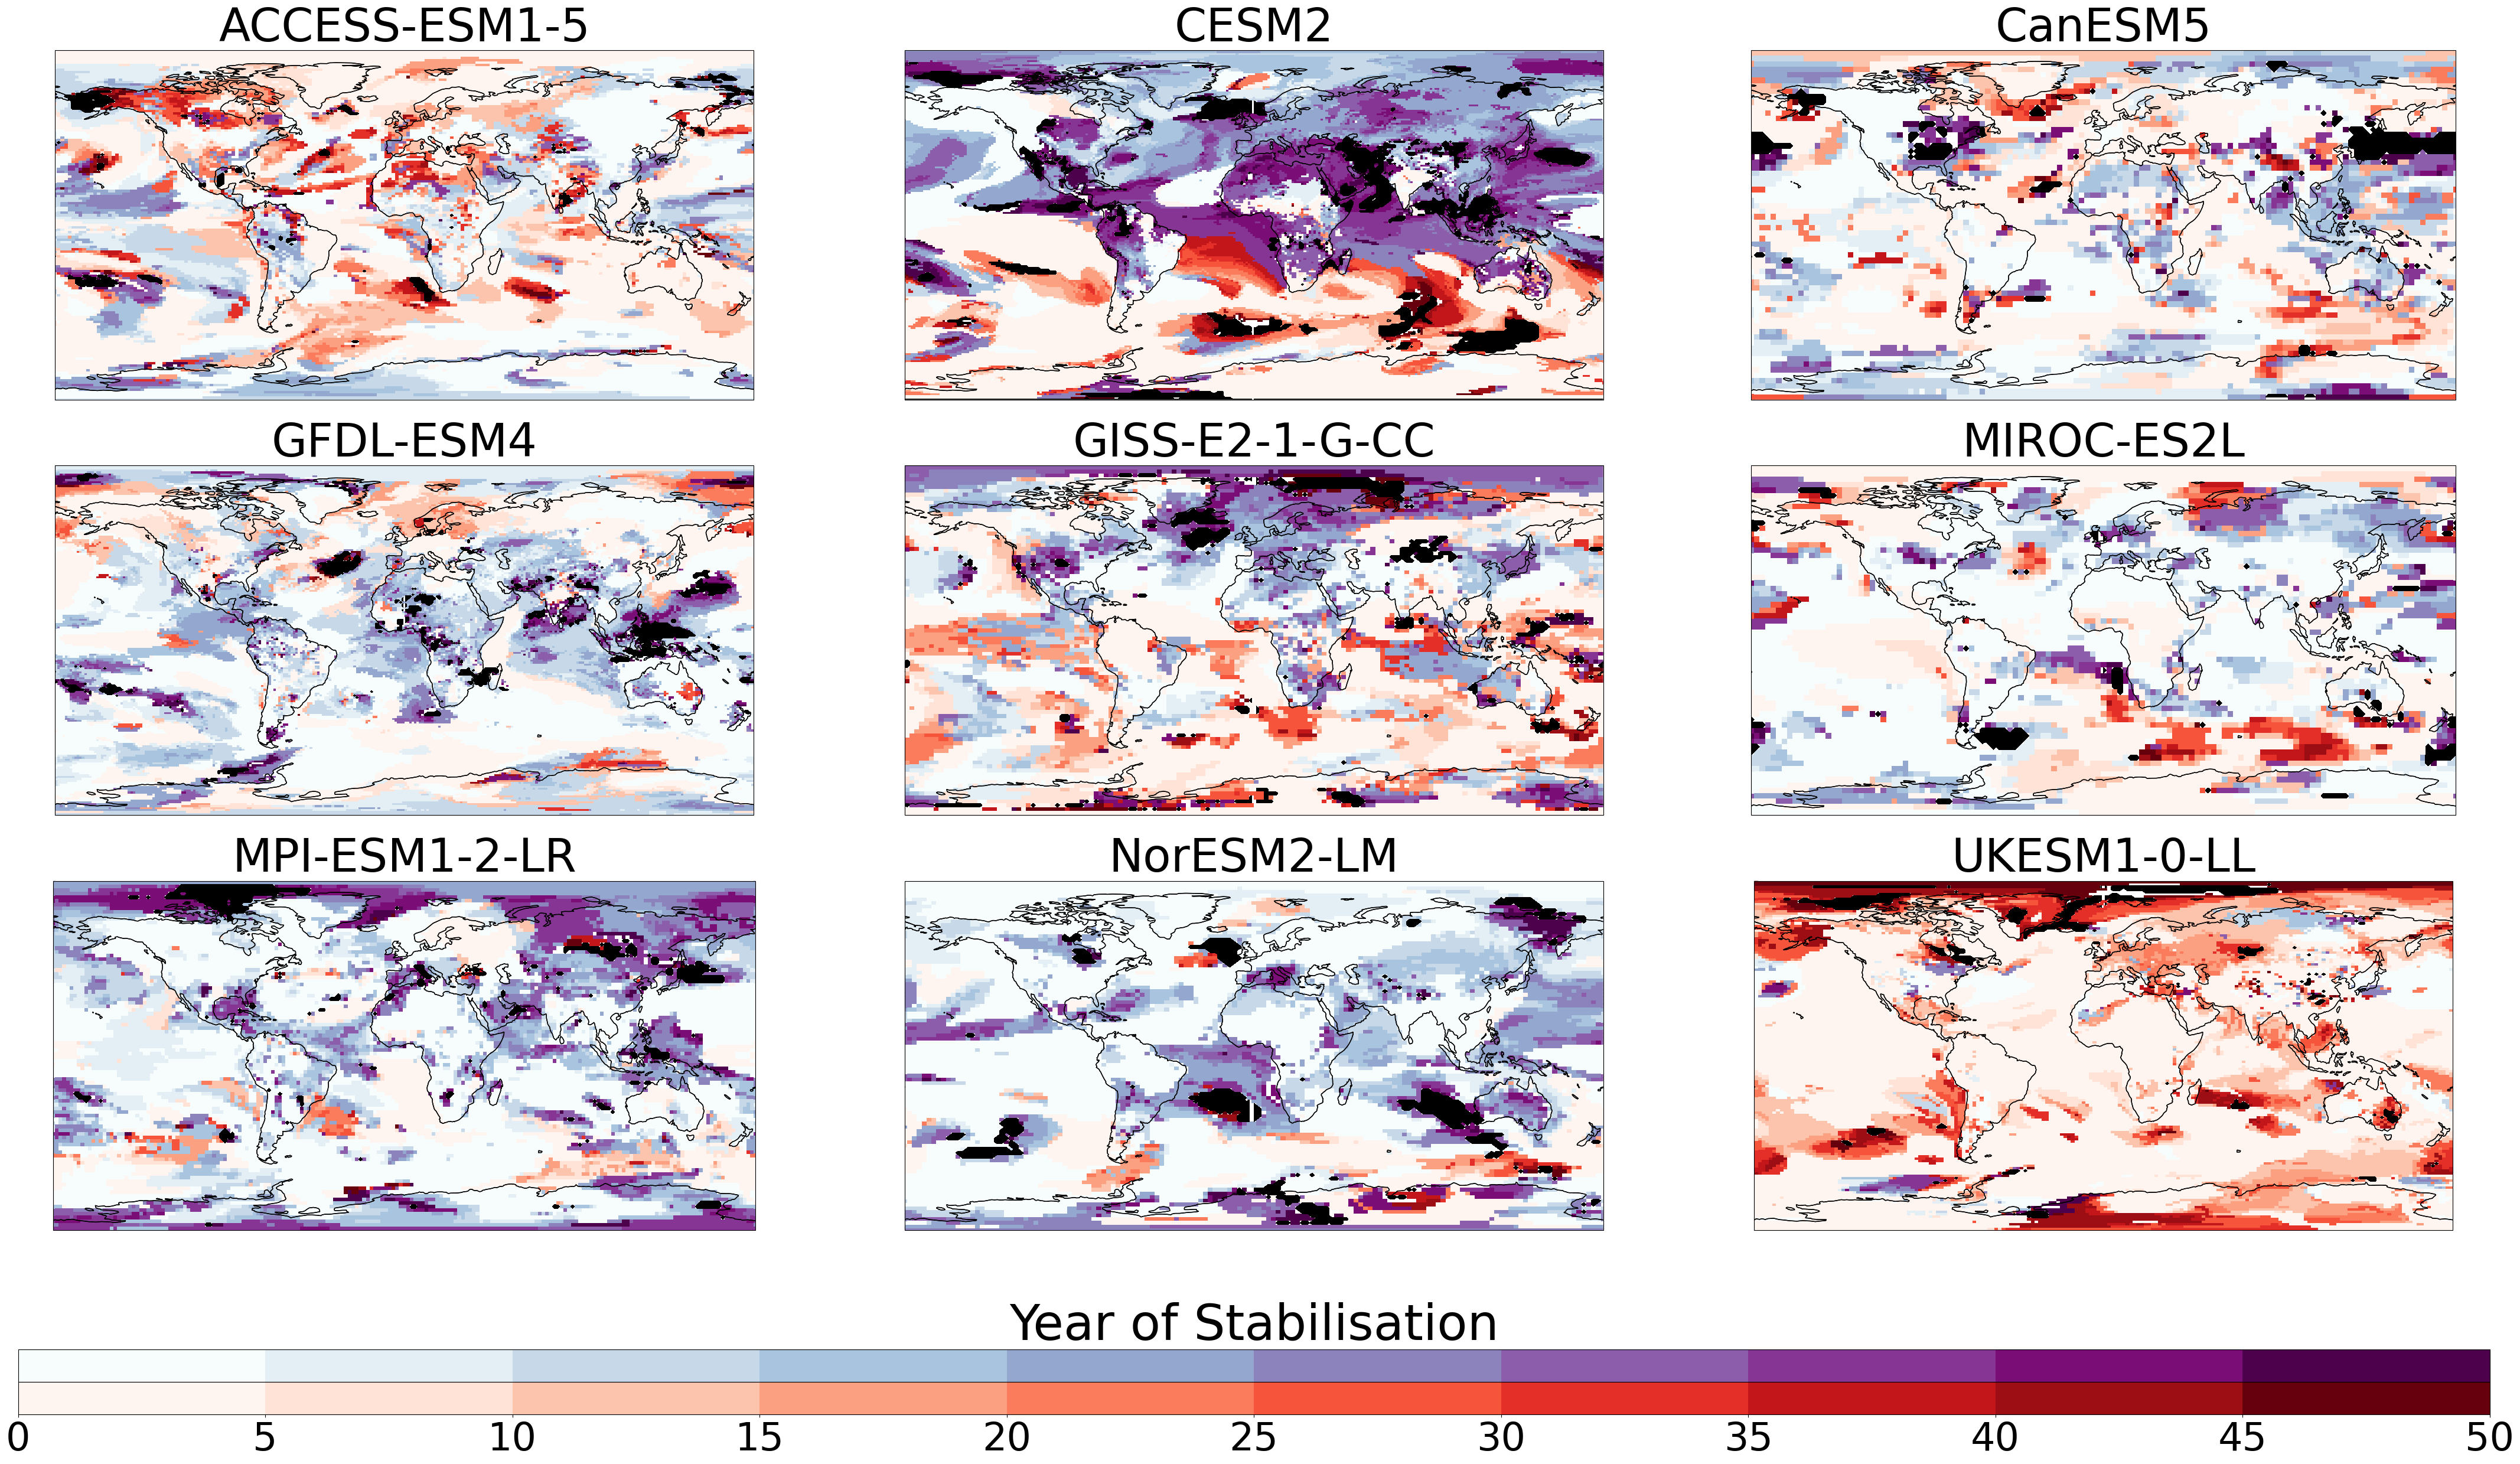

In [153]:

# 20-year window levels
# vm = 30; step=2; levels_stable = np.arange(0, vm+step, step) 
# 40-year window levels
vm = 50; step=5; levels_stable = np.arange(0, vm+step, step) 

ncols, nrows = 3, 3
num_plots = ncols * nrows

fig = plt.figure(figsize=(18*nrows, 10*ncols))
height_ratios = [1]*nrows+[0.15/2]*2
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, wspace=.1, hspace=0.3)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=height_ratios, hspace=0)

axes = [fig.add_subplot(gs_top[i], projection=projection_init) for i in range(0, num_plots)]
cax1 = plt.subplot(gs_bottom[nrows, :])
cax2 = plt.subplot(gs_bottom[nrows+1, :])



### Data plotting
# , stabilisation_method = 'blackout'
stable_plot_kwargs = dict(dim='model', levels=levels_stable, extend='neither', add_label=False,
    max_stabilisation_year=50, stabilisation_method='blackout', 
                          font_scale=2.8, projection=ccrs.PlateCarree, ptype='imshow')

fig, gs, axes, cbar1 = sn_plotting.map_plot_all_for_coords_3(
    stable_cool_data, fig=fig, gs=gs_top, axes=axes, cax=cax1, cmap='BuPu',
    cbar_title="Year of Stabilisation", **stable_plot_kwargs)

fig, gs, axes, cbar2 = sn_plotting.map_plot_all_for_coords_3(
    stable_warm_data, fig=fig, gs=gs_top, axes=axes, cax=cax2, cmap='Reds', **stable_plot_kwargs)

cbar1[0].ax.set_xticklabels([]);
cbar1[0].ax.set_xticks([]);

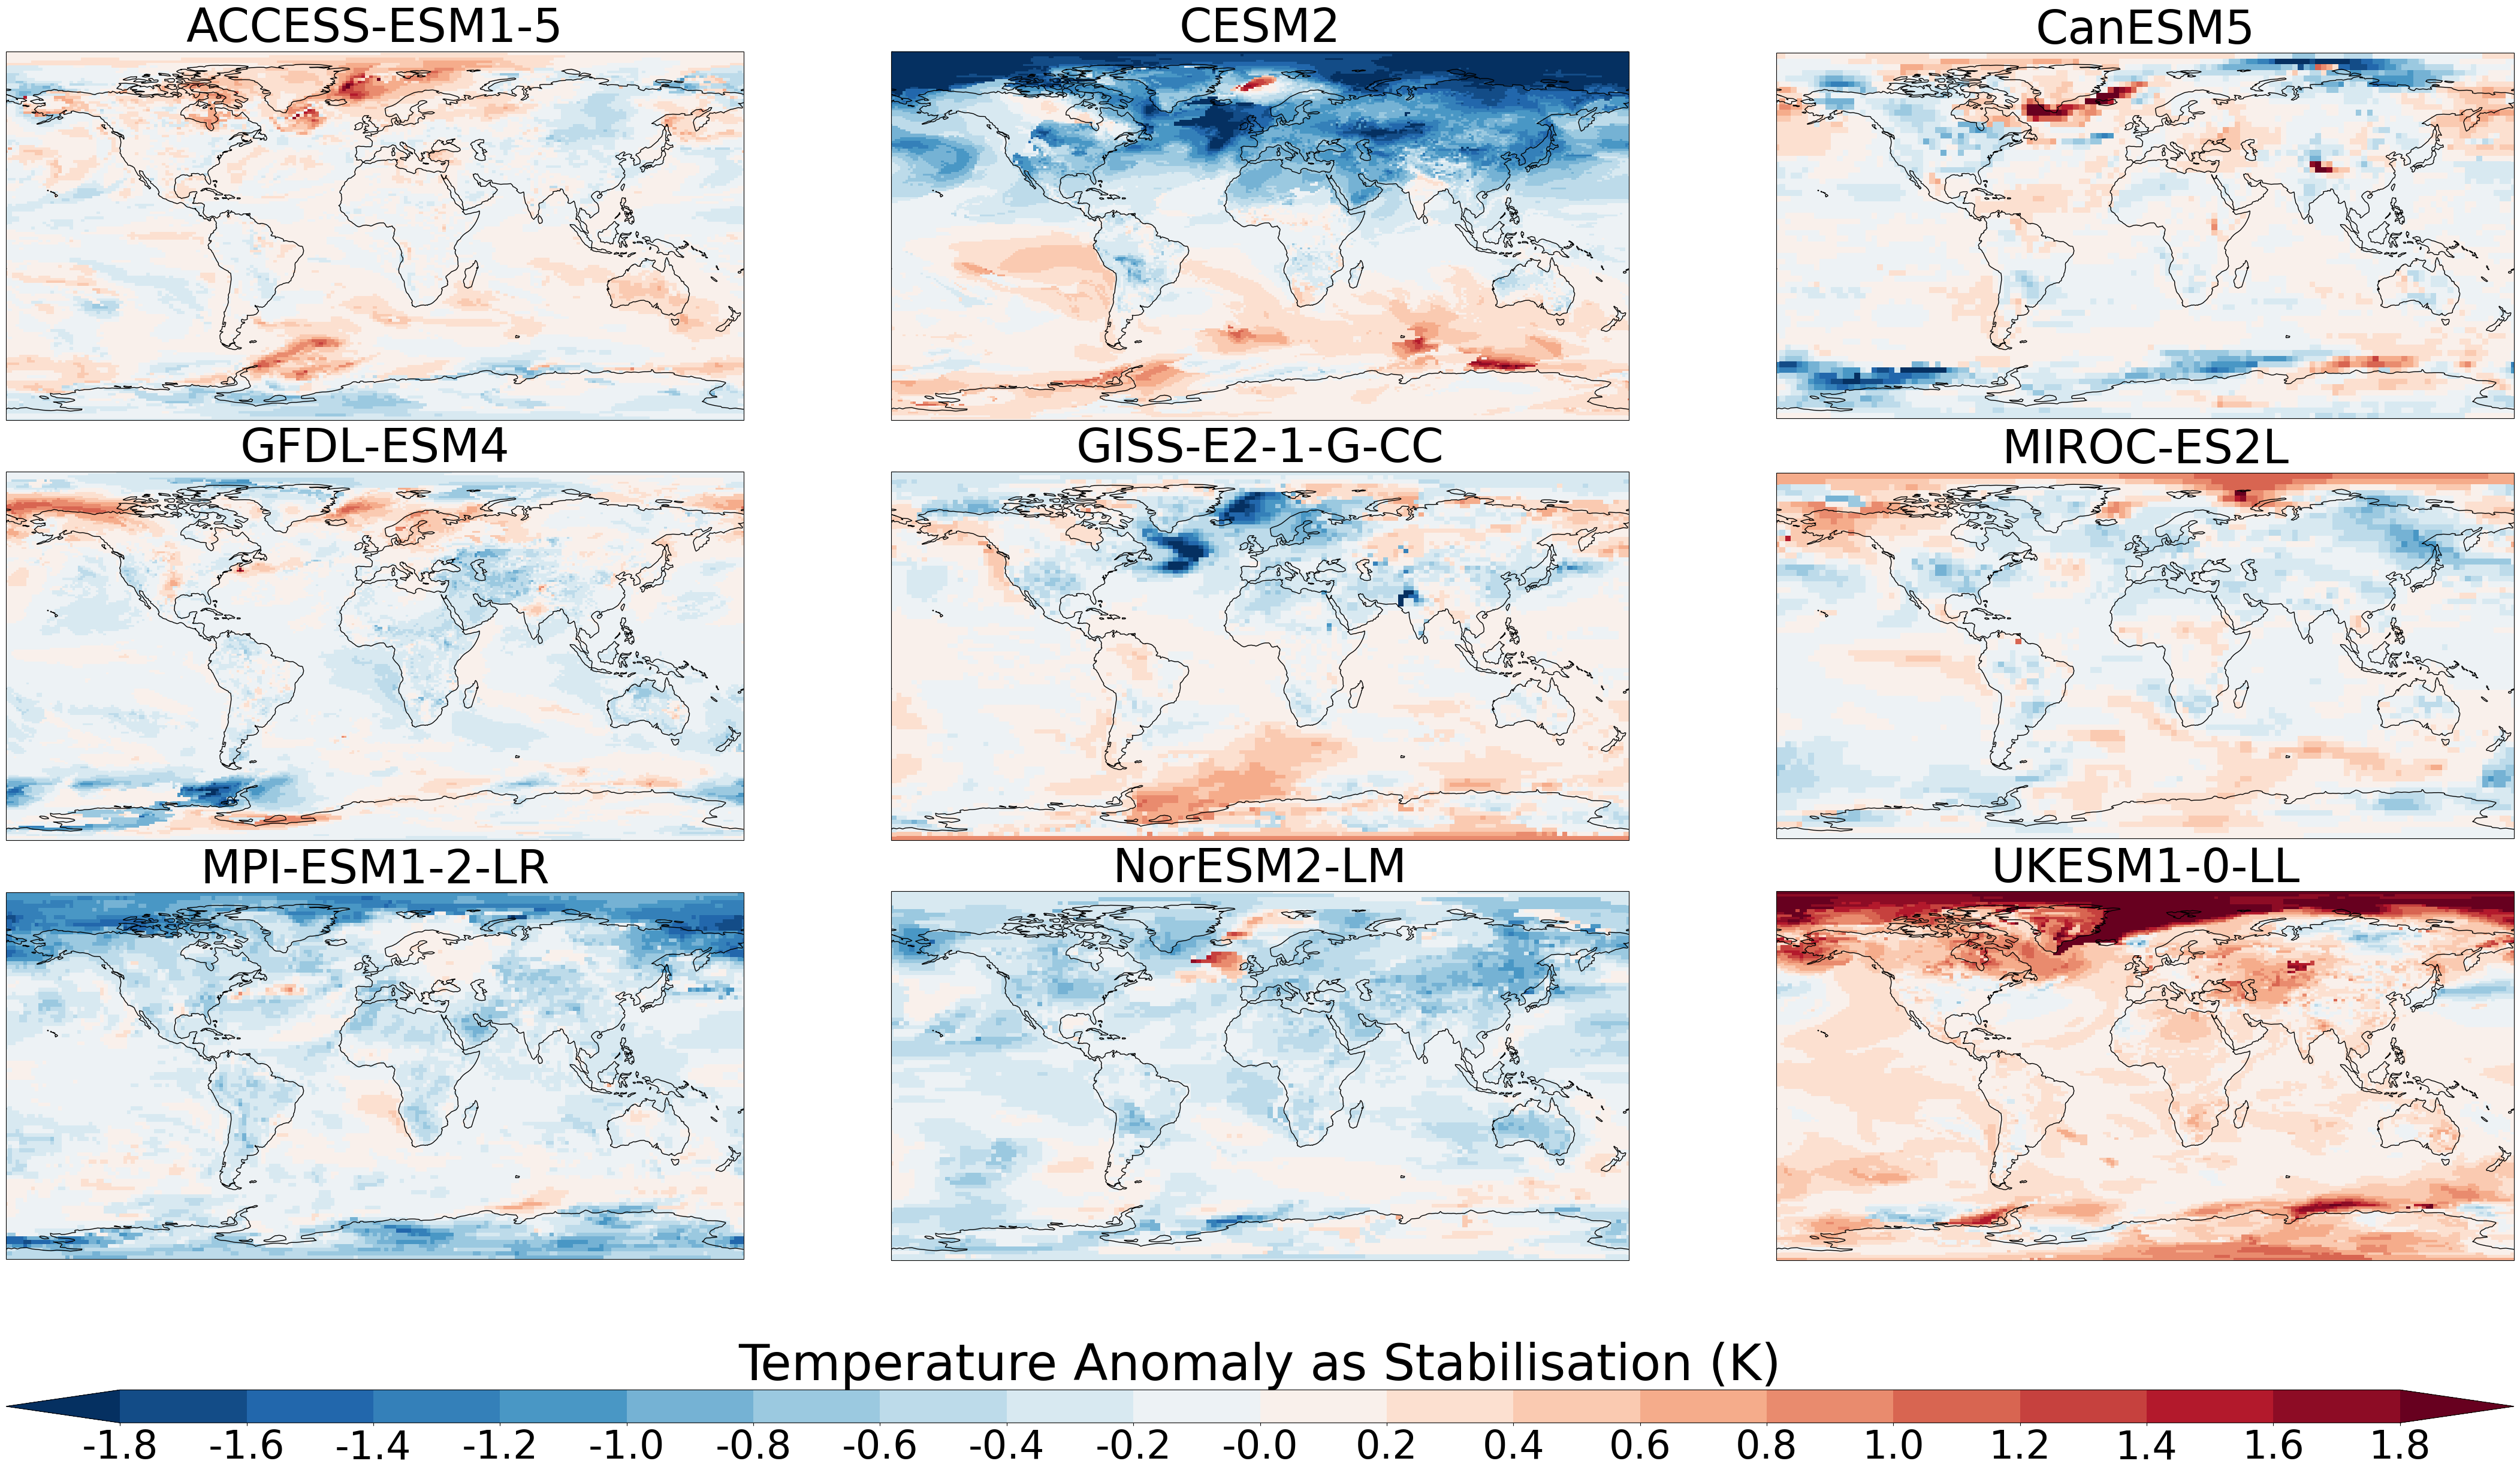

In [154]:
fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.1]+[0.15], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=projection_init) for i in range(0, num_plots)]
cax = plt.subplot(gs_bottom[nrows+1, :])


vm = 1.8; step=.2; levels_anom = np.arange(-vm, vm+step, step) # based upon 99th percentile of abs.
fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    stable_anom_da, dim='model', levels=levels_anom, fig=fig, gs=gs, axes=axes, cax=cax,
    cbar_title="Temperature Anomaly as Stabilisation (K)", projection=ccrs.PlateCarree, 
    add_label=False, font_scale=2.8, 
    logginglevel='ERROR', ptype='imshow')


## Figure 3 (Time series of percent stable)

In [ ]:
### Plot set-up

line_plot_kwargs = dict(xlabel='Time After Emission Cessation (Years)', labelpad=70, ncol=2,
                        font_scale=1.8, xlim=(0, 59), bbox_to_anchor=(1, 0.75))
left_kwargs = dict(ylabel='Percent\nStable (%)')


line_plot_kwargs['ylim'] = (0, 100) #if window == 40 else (40, 100)

### Plot Creation
nplots = len(percent_stable_timeseries_ds.region.values)
fig = plt.figure(figsize=(20, 25))
gs = gridspec.GridSpec(nplots, 1, wspace=0, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(nplots)]

for num, reg in enumerate(percent_stable_timeseries_ds.region.values):
    kwargs_to_use = left_kwargs if ((num%2) or (num==0)) else {}
    sn_plotting.plot_all_coord_lines(
        percent_stable_timeseries_ds.sel(model=models_sorted).sel(region=reg), fig=fig, ax=axes[num],
        title=NAMING_MAP[reg], params=ZEC_LINESTYLE_DICT, 
        add_legend=False,#, if num < len(percent_stable_timeseries_data.region.values)-1 else True,
        logginglevel='ERROR', legend_fontsize=16,
        **kwargs_to_use, **line_plot_kwargs);

# for num, ax in enumerate(axes):
#     title = ax.get_title()
#     ax.set_title('')
#     # Remove the first and last yticks so it doesn't overlap with the next/previous plot.
#     ax.set_yticks(np.take(ax.get_yticks(), np.arange(1, len(ax.get_yticks())-1)))
#     ax.annotate(title, xy=(0.01, 0.85), xycoords='axes fraction', size=plotting_functions.PlotConfig.title_size*1.4)
#     if not num%2 and num >1: ax.set_yticklabels([])
#     if 1 < num < 8: ax.set_xticklabels([]) # Need or the last number can still be seen

In [ ]:
### Plot set-up

line_plot_kwargs = dict(xlabel='Time After Emission Cessation (Years)', labelpad=70, ncol=2,
                        font_scale=1.8, xlim=(0, 59), bbox_to_anchor=(1, 0.75))
left_kwargs = dict(ylabel='Percent\nStable (%)')


line_plot_kwargs['ylim'] = (0, 100) #if window == 40 else (40, 100)

### Plot Creation
nplots = len(percent_stable_timeseries_ds.region.values)+1
fig = plt.figure(figsize=(12*2, 4*nplots))
gs = gridspec.GridSpec(int(np.ceil(nplots/2))+1, 2, height_ratios=[1.5]+[0.2] + [1]*int(np.ceil((nplots-2)/2)), wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, :]); axes = [fig.add_subplot(gs[i+4]) for i in range(nplots-2)]
axes.insert(0, ax0)

for num, reg in enumerate(percent_stable_timeseries_ds.region.values):
    kwargs_to_use = left_kwargs if ((num%2) or (num==0)) else {}
    sn_plotting.plot_all_coord_lines(percent_stable_timeseries_ds.sel(model=models_sorted).sel(region=reg), fig=fig, ax=axes[num],
                                     title=NAMING_MAP[reg], params=ZEC_LINESTYLE_DICT, 
                                     add_legend=False if num < len(percent_stable_timeseries_ds.region)-1 else True,
                                     logginglevel='ERROR', legend_fontsize=16,
                                     **kwargs_to_use, **line_plot_kwargs);

for num, ax in enumerate(axes):
    title = ax.get_title()
    ax.set_title('')
    # Remove the first and last yticks so it doesn't overlap with the next/previous plot.
    ax.set_yticks(np.take(ax.get_yticks(), np.arange(1, len(ax.get_yticks())-1)))
    ax.annotate(title, xy=(0.01, 0.85), xycoords='axes fraction', size=plotting_functions.PlotConfig.title_size*1.4)
    if not num%2 and num >1: ax.set_yticklabels([])
    if 1 < num < 8: ax.set_xticklabels([]) # Need or the last number can still be seen

In [ ]:
### Plot set-up

line_plot_kwargs = dict(xlabel='Time After Emission Cessation (Years)', labelpad=70, ncol=2,
                        exp_type='zecmip', font_scale=1.8, xlim=(0, 59), bbox_to_anchor=(1, 0.75))
left_kwargs = dict(ylabel='Percent\nStable (%)')


line_plot_kwargs['ylim'] = (0, 100) #if window == 40 else (40, 100)

### Plot Creation
nplots = len(percent_stable_timeseries_ds.region.values)+1
fig = plt.figure(figsize=(12*2, 4*nplots))
gs = gridspec.GridSpec(int(np.ceil(nplots/2))+1, 2, height_ratios=[1.5]+[0.2] + [1]*int(np.ceil((nplots-2)/2)), wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, :]); axes = [fig.add_subplot(gs[i+4]) for i in range(nplots-2)]
axes.insert(0, ax0)

for num, reg in enumerate(percent_stable_timeseries_ds.region.values):
    kwargs_to_use = left_kwargs if ((num%2) or (num==0)) else {}
    sn_plotting.plot_all_coord_lines(percent_stable_timeseries_ds.sel(region=reg), fig=fig, ax=axes[num],
                                     title=NAMING_MAP[reg], #linestyle=linestyle_dict, 
                                     add_legend=False if num < len(percent_stable_timeseries_ds.region.values)-1 else True,
                                     logginglevel='ERROR', legend_fontsize=16,
                                     **kwargs_to_use, **line_plot_kwargs);

for num, ax in enumerate(axes):
    title = ax.get_title()
    ax.set_title('')
    # Remove the first and last yticks so it doesn't overlap with the next/previous plot.
    ax.set_yticks(np.take(ax.get_yticks(), np.arange(1, len(ax.get_yticks())-1)))
    ax.annotate(title, xy=(0.01, 0.85), xycoords='axes fraction', size=plotting_functions.PlotConfig.title_size*1.4)
    if not num%2 and num >1: ax.set_yticklabels([])
    if 1 < num < 8: ax.set_xticklabels([]) # Need or the last number can still be seen

In [ ]:

line_plot_kwargs = dict(xlabel='Time After Emission Cessation (Years)', labelpad=70, ncol=2, exp_type='zecmip', font_scale=1.8,
                        xlim=(0, 59), ylim=(0, 100), bbox_to_anchor=(1.1,1))
left_kwargs = dict( ylabel='Percent of\nPoints Stable (%)')

window = 40
plt.style.use('default')
nplots = len(percent_stable_timeseries_ds.region)+1
fig = plt.figure(figsize=(12*2, 4*nplots))
gs = gridspec.GridSpec(int(np.ceil(nplots/2)), 2, height_ratios=[1.5] + [1]*int(np.ceil((nplots-2)/2)), wspace=0.1, hspace=0.4)
ax0 = fig.add_subplot(gs[0, :]); axes = [fig.add_subplot(gs[i+2]) for i in range(nplots-2)]
axes.insert(0, ax0)

for num, reg in enumerate(percent_stable_timeseries_ds.region.values):
    kwargs_to_use = left_kwargs if ((num%2) or (num==0)) else {}
    sn_plotting.plot_all_coord_lines(percent_stable_timeseries_ds.sel(region=reg), fig=fig, ax=axes[num],
                                     title=NAMING_MAP[reg],add_legend=False if num < len(percent_stable_timeseries_ds.region.values)-1 else True, liensytle=linestyles,
                                     **kwargs_to_use, **line_plot_kwargs);
    #axes[num].set_xlim([stable_sn_da.time.values[0], stable_sn_da.time.values[-1]]); axes[num].set_ylim(0, 100)

In [ ]:
line_plot_kwargs_median = dict(xlabel='Time After Emission Cessation (Years)', ylabel='',
                               labelpad=70, font_scale=1.1,xlim=(0, 50), ylim=(0, 101), consensus=False)

fig = plt.figure(figsize=(12, 4*2))
ax = fig.add_subplot(111)

fig, ax, leg = sn_plotting.plot_all_coord_lines(
    percent_stable_timeseries_ds.median(dim='model'),
    ax=ax, coord='region', exp_type='region', linestyle=linestyles, 
    add_legend=True, bbox_to_anchor=(1.03,-0.15), **line_plot_kwargs_median)

ax.set_ylabel('Percent Stable (%)', size=18, ha='left')

# Update the legend elements. Get the legend labels
labels = [text.get_text() for text in leg.get_texts()]
for old_label, new_label in NAMING_MAP.items():
    try:
        leg.get_texts()[labels.index(old_label)].set_text(new_label)
    except ValueError: pass


legend_handles = leg.legendHandles
legend_texts = [t.get_text() for t in leg.get_texts()]
new_order = ['Global'] + [t for t in legend_texts if t != 'Global']

# Create a new legend
leg = ax.legend([handle for _, handle in sorted(zip(legend_texts, legend_handles), 
                                                key=lambda pair: new_order.index(pair[0]))], new_order, 
               fontsize=15)

## Figure 4 (Time series of warming and cooling trneds)

In [ ]:
models = number_cool_data.model.values

In [ ]:
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 1, hspace=0)

ax_left = fig.add_subplot(gs[0])
ax_right = fig.add_subplot(gs[1])


time = number_cool_data[0].time.dt.year.values

for num, model in enumerate(models):
    line_format_dict = dict(
        linestyle = ZEC_LINESTYLE_DICT[model].get('linestyle', '-'),
        color =  ZEC_LINESTYLE_DICT[model].get('color', 'black'),
        linewidth=2)
    

    if 'CanESM5' in model: print(line_format_dict)
    ax_left.plot(time, number_cool_data.sel(model=model).squeeze().values, label='Cooling', **line_format_dict)
    ax_right.plot(time, number_warm_data.sel(model=model).squeeze().values, label='Warming', **line_format_dict)
    
    ytext1 = number_cool_data.sel(model=model).squeeze().values[0]-0.1
    ytext2 = number_warm_data.sel(model=model).squeeze().values[0]-0.1

    # For to plot
    if 'MIROC' in model: ytext1 = ytext1-1.4
    if 'CanESM5' in model: ytext1 = ytext1+1
    if 'GISS' in model: ytext1 = ytext1+0.8


    # For bottom plot
    if 'Nor' in model: ytext2 = ytext2-1
    if 'GISS' in model: ytext2 = ytext2-1
    # if 'ACCESS' in model: ytext2 = ytext2+1
    if 'CanESM5' in model: ytext2 = ytext2+1
    if 'CESM2' in model: ytext2 = ytext2-0.5


    ax_left.annotate(model, xy=(time[0]-0.5, ytext1),ha='right', color=line_format_dict['color'])
    ax_right.annotate(model, xy=(time[0]-0.5, ytext2),ha='right', color=line_format_dict['color'])
    
sn_plotting.format_xticks(ax_right, time, time-1)
sn_plotting.format_xticks(ax_left, time, time-1)

ax_right.set_ylabel('Percent of Surface Area\nnot Stable and Warming (%)', fontsize=14)
ax_left.set_ylabel('Percent of Surface Area\nnot Stable and Cooling (%)', fontsize=14)


for ax in [ax_right, ax_left]:
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    ax.set_xlim(-8, 60)
    ax.set_ylim(0, 65)    

ax_right.set_xlabel('Time After Emission Cessation (Years)', fontsize=14)
ax_left.set_xlabel('Time After Emission Cessation (Years)', fontsize=14)

ax_left.xaxis.set_label_position('top')
ax_left.xaxis.tick_top()

## Supplementary Figures

### Figure S12 (does not stabilise grid cells)

In [ ]:
import matplotlib.colors as mcolors
# Create a custom colormap with two colors: gray and transparent
colors = [(0, 0, 0, 0), 'blue',  '#6c5ce7', 'black']#(0.5, 0.5, 0.5, 1)]  # (R, G, B, Alpha)
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [ ]:
colors = np.concatenate([[[1,1,1,1]], plt.get_cmap('cool')(np.linspace(0, 1, 3))])
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [ ]:
cmap_binary

In [ ]:
def stability_achieved_rank(val):
    '''
    Defines the 

    '''
    if val >= 60: return 3
    if val >= 50: return 2
    if val >= 40: return 1
    return 0
    

In [ ]:
stability_achieved_rank = np.vectorize(stability_achieved_rank)

In [ ]:
stability_achieved_rank_data = year_stable_data(xr.zeros_like) + year_stable_data(stability_achieved_rank)

In [ ]:
stability_achieved_rank_data

In [ ]:

# 20-year window levels
# vm = 30; step=2; levels_stable = np.arange(0, vm+step, step) 
# 40-year window levels
vm = 60; step=5; levels_stable = np.arange(0, vm+step, step) 

ncols, nrows = 3, 3
num_plots = ncols * nrows

fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.15]*2, wspace=.1)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.15]*2, hspace=0)

axes = [fig.add_subplot(gs_top[i], projection=projection_init) for i in range(0, num_plots)]
cax1 = plt.subplot(gs_bottom[nrows+0, :])

stable_plot_kwargs = dict(dim='model', extend='neither', add_label=False,
    max_stabilisation_year=60, font_scale=2, projection=ccrs.PlateCarree, ptype='imshow')

fig, gs, axes, cbar1 = sn_plotting.map_plot_all_for_coords_3(
    stability_achieved_rank_data, 
    fig=fig, gs=gs_top, axes=axes, cax=cax1, cmap=cmap_binary, levels=[0, 1, 2, 3,5],
    cbar_title="", **stable_plot_kwargs)

cbar1[0].ax.set_xticks([0.5,1.5, 2.5, 4])
cbar1[0].ax.set_xticklabels(['Stablises before year 40', 'Stabiliastion between\nyear 40 and 50', 
                             'Stabiliastion between\nyear 50 and 60',
                             'Does not stabilise'])
cbar1[0].ax.tick_params(labelsize=44)  # Set font size to 14

In [ ]:

# 20-year window levels
# vm = 30; step=2; levels_stable = np.arange(0, vm+step, step) 
# 40-year window levels
vm = 60; step=5; levels_stable = np.arange(0, vm+step, step) 

ncols, nrows = 3, 3
num_plots = ncols * nrows

fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs_top = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.15]*2, wspace=.1)
gs_bottom = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.15]*2, hspace=0)

axes = [fig.add_subplot(gs_top[i], projection=projection_init) for i in range(0, num_plots)]
cax1 = plt.subplot(gs_bottom[nrows+0, :])



### Data plotting
# , stabilisation_method = 'blackout'
stable_plot_kwargs = dict(dim='model', extend='neither', add_label=False,
    max_stabilisation_year=60, font_scale=2, projection=ccrs.PlateCarree, ptype='imshow')

fig, gs, axes, cbar1 = sn_plotting.map_plot_all_for_coords_3(
    where(year_stable_data >=60, 1, 0), 
    # xr.where(year_stable_data >50, 1, 0), 
    fig=fig, gs=gs_top, axes=axes, cax=cax1, cmap=cmap_binary, levels=[0, 1, 2],
    cbar_title="", **stable_plot_kwargs)

cbar1[0].ax.set_xticks([0.5,1.5])
cbar1[0].ax.set_xticklabels(['Stablises before year 50', 'Stabilises after year 50'])
cbar1[0].ax.tick_params(labelsize=44)  # Set font size to 14

### Figure S13 (stability bounds)

In [ ]:
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(4, 3, height_ratios = [0.05] + [1]*3, hspace=0)
axes = [fig.add_subplot(gs[i+3], projection=ccrs.PlateCarree(central_longitude=180)) for i in range(9)]
# axes= [fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree()), 
#        fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())]

fig, gs, axes, cax = sn_plotting.map_plot_all_for_coords_3(
    sn_ratio_bounds_data.lower_bound.mean(dim='window'), dim='bound',
    levels=sn_levels, projection=projection, cmap=sn_cmap, font_scale=0.9,
    cbar_title="Signal-to-Noise Ratio", extend='neither',
    fig=fig, gs=gs,
    axes =axes,
    cax = plt.subplot(gs[0, :]),
    add_colorbar=True,
)

# axes[0].set_title('Lower S/N Rario Bound', fontsize=14)
# axes[1].set_title('Upper S/N Ratio Bound', fontsize=14)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
lat_lon_dict = dict(lat=80, lon=67.5, method='nearest')

model = 'ACCESS-ESM1-5'
ax1.plot(esmpi_data[model].sel(**lat_lon_dict).isel(time=slice(0,500)).squeeze().values,
        color='green', alpha=0.7, linewidth=1.7,);
ax2.plot(a1_anom_data[model].sel(**lat_lon_dict).squeeze().values,
         color='green', linewidth=1.7, alpha=0.7);

# slope, fitted_line = calculate_slope_and_line(
#     a1_anom_data[model].sel(**lat_lon_dict).squeeze().values)
# ax2.plot(np.arange(len(fitted_line)), fitted_line, 
#         color='black', linewidth=2)

ax2.plot(
    (a1_anom_data[model].sel(**lat_lon_dict).squeeze()
     .rolling(time=20, center=True).mean().values),
color='blue', linewidth=1.7, alpha=0.7, linestyle='--', label='Rolling 20-year mean');

ax2.plot(np.arange(40, 61),
    np.tile(zec50_data[model].sel(**lat_lon_dict).values, 21),
        linewidth=2.5, color='magenta', label='ZEC'+r'$_{50}$')

ax2.plot(np.arange(
    year_stable_data[model].sel(**lat_lon_dict).values,
    year_stable_data[model].sel(**lat_lon_dict).values+21),
    np.tile(stable_anom_da[model].sel(**lat_lon_dict).values, 21),
        linewidth=2.5, color='magenta', linestyle='--', 
        label='Temperature Anomaly at Stabilisation')

ax2.legend(ncol=2, fontsize=12)

plotting_functions.format_axis(
    ax1, xlabel='Time After Simulation Start (Years)', title=f'{model} (75N, 40S)',
    ylabel='GMST'+r' ($^{\circ}C$)',
    labelpad=55, invisible_spines=['top', 'right'])



ax2.yaxis.set_major_locator(mticker.MultipleLocator(1))
ax2.yaxis.set_minor_locator(mticker.MultipleLocator(.5))

plotting_functions.format_axis(
    ax2, xlabel='Time After Emission Cessation (Years)', title='',
    ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
    labelpad=55, invisible_spines=['top', 'right'])

# ax1.set_xticklabels(a1_anom_data.isel(time=slice(14, 60)).time.dt.year.values[::15])

In [ ]:
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(4, 3, height_ratios=[0.15, 1, 1, 1], hspace=0.4) 

axes =[fig.add_subplot(gs[i+3]) for i in range(9)]
# Create a position for the colorbar on top
cbar_ax = fig.add_subplot(gs[0, :])

# Define levels for the discrete colorbar
levels = np.arange(-2.5, 2.75, 0.25)

# Create a colormap and normalize with the levels
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Create subplots
for num, model in enumerate(static_noise_data.model):
    ax = axes[num]
    ax.grid(True, linestyle='--', color='grey', alpha=0.6, zorder=-1000)

    sc = ax.scatter(static_noise_data[model].values.flatten(),
                    year_stable_data[model].values.flatten(), 
                    c=stable_anom_a.sel(model=model).values.flatten(), cmap=cmap, norm=norm) 
    #zec50_data, stable_anom_da
    ax.set_title(model, fontsize=18)
    ax.set_xlim(0,4)
    ax.set_ylim(0, 60)
    
# Add the colorbar
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_title('Temperature Anomaly at Stabilisation ' + r'$ (^\circ C)$', fontsize=18)

cbar.ax.tick_params(labelsize=16)  # Increase font size of the tick labels

axes[3].set_ylabel('Year of Stabilisation', fontsize=18)
axes[7].set_xlabel('Standard Deviation'  + r'$ (^\circ C)$', fontsize=18)


In [ ]:
arr = a1_anom_data[model].sel(**lat_lon_dict).squeeze().values
arr.shape

In [ ]:
window = 30
signal_list = []
noise_list = []
for t in range(len(arr)-window):
    arr_subset = arr[t:t+window]
    slope = calculate_slope(arr_subset) * window
    noise = np.std(arr_subset)
    signal_list.append(slope)
    noise_list.append(noise)
signal_list = np.array(signal_list)
noise_list = np.array(noise_list)
sn_list = signal_list/noise_list

In [ ]:
actual_values = sn_ratio_a1_data.sel(model=model).sel(**lat_lon_dict).sel(window=window).squeeze().values

In [ ]:
a1_anom_detrend_data.sel(model=model).sel(**lat_lon_dict).plot()
a1_anom_data.sel(model=model).sel(**lat_lon_dict).plot()

In [ ]:
# plt.plot(actual_values)
plt.plot(sn_list, label='test')
plt.plot(actual_values, label='actual')
plt.legend()

In [ ]:
diff_stable_and_zec50_data = zec50_data - stable_anom_da

In [ ]:
fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.1]+[0.15], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=projection_init) for i in range(0, num_plots)]
cax = plt.subplot(gs_bottom[nrows+1, :])


vm = 1.5; step=.3; levels_diff= np.arange(-vm, vm+step, step) # based upon 99th percentile of abs.
fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    diff_stable_and_zec50_data, dim='model', levels=levels_diff, fig=fig, gs=gs, axes=axes, cax=cax,
    cbar_title="ZEC" + r'$_{50}$' + ' - Temperature Anomaly at Stabilisation ' + r'$(^\circ C)$', 
    projection=ccrs.PlateCarree, 
    add_label=False, font_scale=2.8, 
    logginglevel='ERROR', ptype='imshow')


# TCRE local ZEC correlation

In [ ]:
ecs_dict = {
    'NorESM2-LM': 2.54,
    'MIROC-ES2L': 2.7,
    'MPI-ESM1-2-LR': 2.83,
    'GISS-E2-1-G-CC': 2.9,
    'GFDL-ESM4': 3.1,
    'ACCESS-ESM1-5': 3.87,
    'CESM2': 5.1,
    'UKESM1-0-LL': 5.4,
    'CanESM5': 5.7
}

In [ ]:
# This comes from the ZEC nat var paper
tcre_dict = {
    'ACCESS-ESM1-5': 1.81,
    'CESM2': 2.01,
    'CanESM5': 2.10,
    'GFDL-ESM4': 1.36,
    'GISS-E2-1-G-CC': 1.68,
    'MIROC-ES2L': 1.36,
    'MPI-ESM1-2-LR': 1.65,
    'NorESM2-LM': 1.42,
    'UKESM1-0-LL': 2.65
}

In [ ]:
from scipy.stats import spearmanr

In [ ]:
def apply_correlation(arr1, arr2):
    if np.all(np.isnan(arr1)) or np.all(np.isnan(arr2)): return np.nan

    finite_locs = np.isfinite(arr1)
    arr1 = arr1[finite_locs]
    arr2 = arr2[finite_locs]

    return spearmanr(arr1, arr2).statistic

In [ ]:
list(tcre_dict.values())

In [ ]:
apply_correlation_tcre = partial(apply_correlation, arr2=np.array(list(tcre_dict.values())))
tcre_correlation = xr.apply_ufunc(
    apply_correlation_tcre,
    stable_anom_da.sel(model=list(tcre_dict)), # make sure same order
    input_core_dims=[['model']], 
    output_core_dims=[[]],
    vectorize=True
)

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tcre_correlation.plot(ax=ax, levels=np.arange(-1, 1.1, .1))
ax.coastlines()

In [ ]:
apply_correlation_ecs = partial(apply_correlation, arr2=np.array(list(ecs_dict.values())))
ecs_correlation = xr.apply_ufunc(
    apply_correlation_ecs,
    stable_anom_da.sel(model=list(tcre_dict)), # make sure same order
    input_core_dims=[['model']], 
    output_core_dims=[[]],
    vectorize=True
)

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ecs_correlation.plot(ax=ax, levels=np.arange(-1, 1.1, .1))
ax.coastlines()

In [ ]:
stable_anom_da.sel(model=list(tcre_dict))

# Drift Comparison (Figure S11)

In [ ]:
#### TODO: Do not import as *. Add drift_functino. as prefix to all necissary functions
from drift_functions import *

In [ ]:
# P-values
pi_pval_da = calculate_pvals(
    esmpi_data.chunk({'time':-1, 'model':1, 'lat': int(96/4)}).isel(time=slice(0, 100)))

In [ ]:
a1_anom_data

In [ ]:
exp_pval_da = calculate_pvals(a1_anom_data)

In [ ]:
exp_pval_da.isel(model=0).plot()

In [ ]:
# Just the p-values that are less tha 0.05
pi_sig_da = xr.where(pi_pval_da < 0.05, 1, np.nan)#.astype(int)
exp_sig_da = xr.where(exp_pval_da < 0.05, 1, np.nan)#.astype(int)

In [ ]:
fig = plt.figure(); ax = fig.add_subplot(111, projection=ccrs.Robinson())
sn_plotting.plot_stippled_data(pi_sig_da.isel(model=0), ax)

In [ ]:
# Calculating the gradient over the 100 year run length
gradient_exp_full_da = calculate_trend(a1_anom_data);
gradient_pi_full_da = calculate_trend(esmpi_data.isel(time=slice(0, 100)))

In [ ]:
# Multiplying gradient by 50 to get K per 50 years
gradient_exp_full_da = (gradient_exp_full_da*50).persist()
gradient_pi_full_da = (gradient_pi_full_da*50).persist()

In [ ]:
# Difference in the gradients
gradient_full_diff = gradient_exp_full_da-gradient_pi_full_da

In [ ]:
reload(sn_plotting)

In [ ]:
# All mean value plots
models = gradient_full_diff.model.values
nrows = len(models); ncols = 3
fig = plt.figure(figsize=(6*ncols, 8*ncols))
gs = gridspec.GridSpec(nrows+1, ncols, height_ratios = [1]*nrows +[0.2], hspace=.2, wspace=0)
projection = ccrs.PlateCarree(central_longitude=int(np.mean(gradient_full_diff.lon.values)))

drift_plot_levels = np.arange(-1.4, 1.4, .2)
drift_plot_kwargs = dict(levels=drift_plot_levels, extend='both', cmap='RdBu_r', add_label=False, font_scale=0.7)
vm =40; step=5; levels_mean_stab2 = np.arange(0, vm+step, step)
all_axes = []

### A1

fig, gs, axes1 = sn_plotting.map_plot_all_for_coords_3(
    gradient_exp_full_da, dim='model',
    fig=fig, gs=gs, add_colorbar=False, stipling_da=exp_sig_da,
    axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(len(models))],
    **drift_plot_kwargs)

for num, (ax, model) in enumerate(zip(axes1, models)):
    # ax.set_ylabel(model, labelpad=500)
    # sn_plotting.plot_stippled_data(pi_sig_da.sel(model=model), ax) # TODO: This is not working in the `map_plot_all_for_coords_3` function
    if num == 0: ax.set_title('A1 Experiment', fontsize=plotting_functions.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
    else: ax.set_title('')
    
y_axis_kwargs = dict(xy=(-.25, 0.5), ha='center', va='center', xycoords='axes fraction', rotation=0,
                     size=plotting_functions.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
for model, ax in zip(models, axes1): ax.annotate(model, **y_axis_kwargs)
all_axes.extend(axes1)


#### Pi-control

fig, gs, axes2 = sn_plotting.map_plot_all_for_coords_3(
    gradient_pi_full_da, dim='model',
    fig=fig, gs=gs, add_colorbar=False,stipling_da=pi_sig_da, 
    axes = [fig.add_subplot(gs[i, 1], projection=projection) for i in range(len(models))],
    **drift_plot_kwargs)
for ax in axes2: ax.set_title('')
axes2[0].set_title('Pre-Industrial Control', size=plotting_functions.PlotConfig.title_size*drift_plot_kwargs['font_scale'])

all_axes.extend(axes2)

### Diff

fig, gs, axes3, cbar = sn_plotting.map_plot_all_for_coords_3(
    gradient_full_diff, dim='model',
    cbar_title="Gradient (K /(50 year))", fig=fig, gs=gs,
    axes = [fig.add_subplot(gs[i, 2], projection=projection) for i in range(len(models))],
    cax = plt.subplot(gs[nrows, :]), 
    **drift_plot_kwargs)


for ax in axes3: ax.set_title('')
axes3[0].set_title('Difference', size=plotting_functions.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
all_axes.extend(axes3)

#for num, ax in enumerate(all_axes): plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.7)